# CAR T Interaction Modeling with DIISCO

In [6]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline
import seaborn as sns
#import tensorflow as tf
#from Scalable_GPRN.model.SGPRN import SGPRN
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
# reload edited modules always
%load_ext autoreload
%autoreload 2
from diisco import DIISCO
import diisco.names as names


In [7]:
torch.set_default_dtype(torch.float64)

In [8]:
# df = pickle.load(open('data/CAR-T ratios and umap/CARD_ratios.pkl', "rb"))
# cell_types = ['CLL', 'CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
# df.columns = cell_types + ['total_cells_per_sample']
# # CARA expriment timestamps (hours post co-culture)
# df.index = [0, 5/60, 15/60, 30/60, 1, 2, 4, 8.5, 12.5, 20.5]
# df.index.name = 'Hours post co-culture'
# df.to_csv('data/CAR-T ratios and umap/CARD_ratios_processed.pkl')

## Experiment A

In [9]:
df = pd.read_csv('../../data/CAR-T ratios and umap/CARA_ratios_processed.pkl', index_col='Hours post co-culture')
df.columns = ['CLL', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells',
              'total_cells_per_sample']
df

,CLL,Other CD8+ T cells,Activated T cells,Exhausted T cells,total_cells_per_sample
Hours post co-culture,,,,,
0.000000,0.752294,0.192661,0.045872,0.009174,109.0
0.083333,0.841463,0.121951,0.000000,0.036585,82.0
0.250000,0.785311,0.169492,0.028249,0.016949,177.0
0.500000,0.728745,0.222672,0.044534,0.004049,247.0
0.750000,0.837553,0.111814,0.042194,0.008439,474.0
1.000000,0.844660,0.101942,0.043689,0.009709,206.0
2.000000,0.752941,0.088235,0.132353,0.026471,340.0
4.000000,0.588486,0.063966,0.251599,0.095949,469.0
12.000000,0.473214,0.017857,0.028274,0.480655,672.0


Text(0.5, 1.0, 'Number of cells over time by cell type \n (cell type proportion * total_cells_per_sample)')

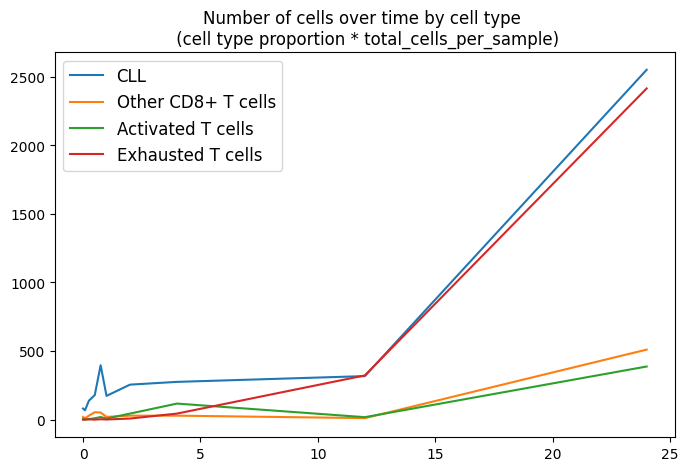

In [10]:
plt.figure(figsize=(8, 5))
cell_types = ['CLL', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
for cell_type in cell_types:
    plt.plot(df[cell_type] * df['total_cells_per_sample'], label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Number of cells over time by cell type \n (cell type proportion * total_cells_per_sample)', 
          fontsize=12)

Text(0.5, 1.0, 'Proportion of cells over time by cell type')

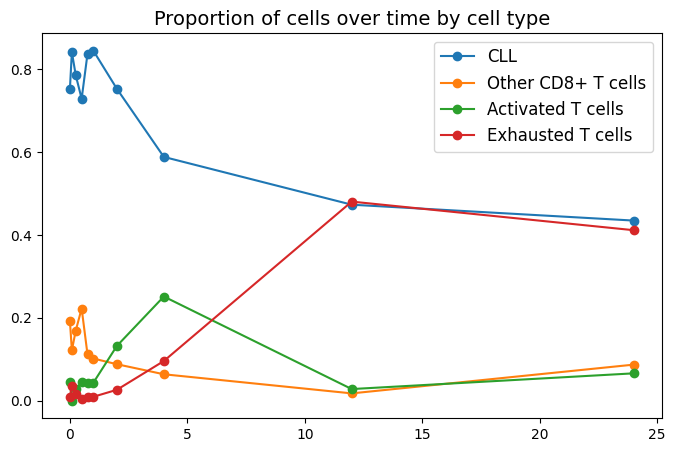

In [11]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper right', fontsize=12)
# plt.ylim([-0.5, 0.5])
plt.title('Proportion of cells over time by cell type', fontsize=14)

Center cell type proportions

In [12]:
#cell_type_means = df[cell_types].mean()
#df[cell_types] -= cell_type_means
#df

Text(0.5, 1.0, 'Proportion (zero-centered) of cells over time by cell type')

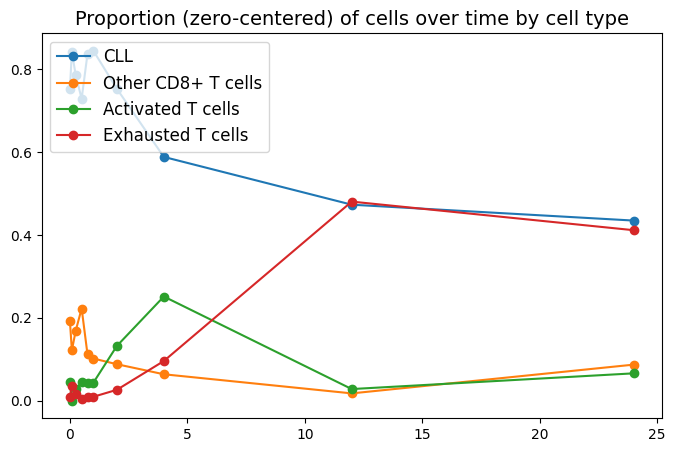

In [13]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Proportion (zero-centered) of cells over time by cell type', fontsize=14)

In [14]:
# X = np.linspace(0, df.shape[0]-1, df.shape[0]).reshape(-1, 1)
X = df.index.values.reshape(-1, 1)
X[:3]

array([[0.        ],
       [0.08333333],
       [0.25      ]])

In [15]:
Y = df[cell_types].values
Y

array([[0.75229358, 0.19266055, 0.04587156, 0.00917431],
       [0.84146341, 0.12195122, 0.        , 0.03658537],
       [0.78531073, 0.16949153, 0.02824859, 0.01694915],
       [0.72874494, 0.22267206, 0.04453441, 0.00404858],
       [0.83755274, 0.11181435, 0.04219409, 0.00843882],
       [0.84466019, 0.10194175, 0.04368932, 0.00970874],
       [0.75294118, 0.08823529, 0.13235294, 0.02647059],
       [0.58848614, 0.06396588, 0.25159915, 0.09594883],
       [0.47321429, 0.01785714, 0.02827381, 0.48065476],
       [0.43490872, 0.08718649, 0.06620031, 0.41170449]])

In [16]:
# Sweep out timepoints between 0 and 24 to predict on
X_test = np.linspace(start=0, stop=df.index[-1], num=100).reshape(-1, 1)

# Placeholder Y_test just for the SGPRN API
Y_test = np.zeros((X_test.shape[0], Y.shape[1]))

# For plotting uncentered points
Y_uncentered = Y #+ cell_type_means.values

Add priors for $f_i$'s based on mean of independent GP fits

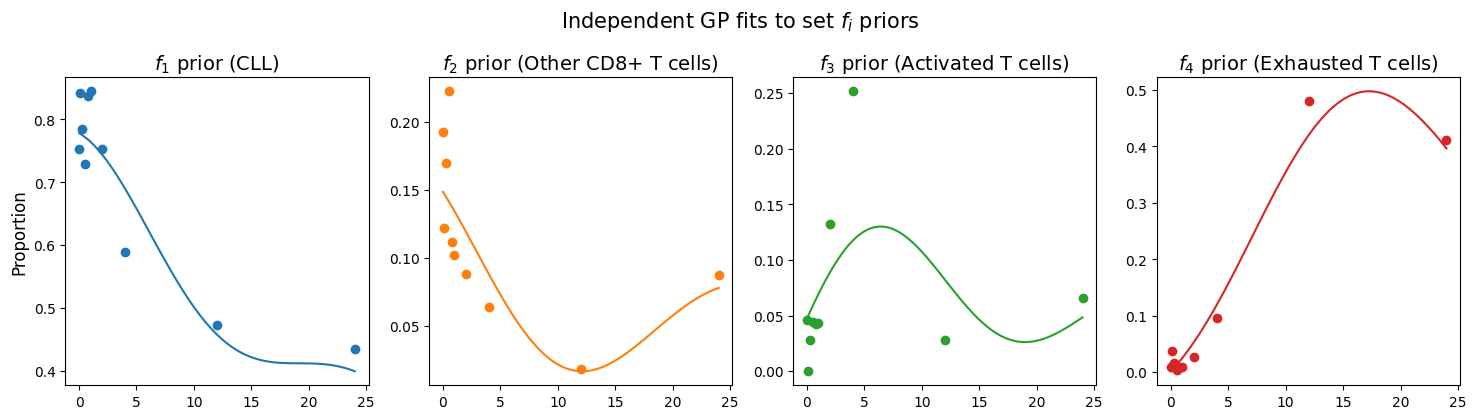

In [17]:
f_priors = []
cell_type_color = [('CLL', 'tab:blue'), 
                   ('Other CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]
plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    rbf = RBF(length_scale=10, length_scale_bounds=(10, 10))
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.1, random_state=0, optimizer=None)
    gpr.fit(X, y_i.reshape(-1, 1))
    y_pred = gpr.predict(X_test)
    f_priors.append(gpr.predict(X))
    plt.subplot(1, 4, i+1)
    plt.plot(X_test, y_pred , c=cell_type_color[i][1])
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1])
    plt.title('$f_%s$ prior (%s)' % (i+1, cell_type_color[i][0]), fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
plt.suptitle('Independent GP fits to set $f_i$ priors', fontsize=15, y=1.05)
f_priors = np.array(f_priors)

Add regularization for $W$

Text(0.5, 1.0, '$W$ regularization penalty')

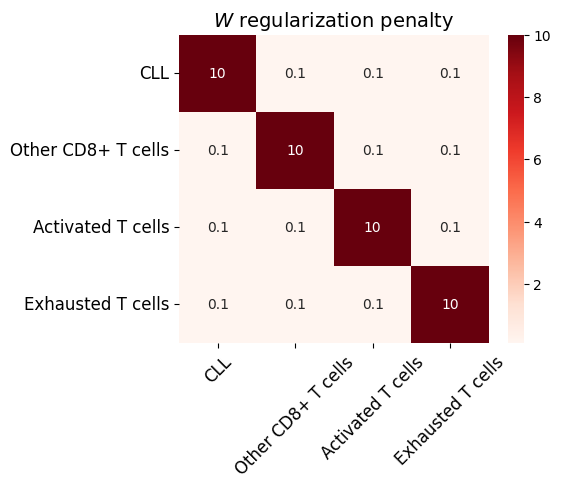

In [18]:
W_reg_lambdas = np.array([[ 10, 0.1, 0.1, 0.1], 
                          [0.1,  10, 0.1, 0.1], 
                          [0.1, 0.1,  10, 0.1], 
                          [0.1, 0.1, 0.1, 10]])

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_reg_lambdas, cmap="Reds", annot=True)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$W$ regularization penalty', fontsize=14)

In [19]:
priors = {
    # f priors based on independent GP fits
    'F': f_priors.T.reshape(10, 4, 1),
#     'W': W_prior_mean,
#     'W_prior_min': W_prior_min,
#     'W_prior_max': W_prior_max,
    # default GPRN W prior
    'W': tf.Variable(0.001*tf.random.truncated_normal([10, 4, 4], mean=0, stddev=1.0), 
                     dtype=tf.float32),
    'W_reg_lambdas': W_reg_lambdas
}

NameError: name 'tf' is not defined

In [20]:
data = {
    'N_all': X.shape[0],
    'N_train': X.shape[0],
    'N_test': X.shape[0],
    'X_all': X,
    'Y_all': Y,
    'X_train': X,
    'X_test': X_test,
    'Y_train': Y,
    'Y_test': Y_test,
    'Y_mean': 0,
    'Y_std': 1,
    'Y_test_ground': Y,
    'DList': [4, 1, 1],
    'dname': 'None'
}

kernel = 'rbf'
f_kernel_bandwidth = 100
f_sigma = 0
W_kernel_bandwidth = 100
rank = 4
maxIter = 500
interval = 100

cfg = {
    'data': data,
    'jitter': 1e-3,
    'init_std': 1e-3,
    'epochs': maxIter,
    'interval':interval,
    'alpha':1e-2,
    'ns': 100,
    'Q': rank,
    'kernel': kernel,
    'f_kernel_bandwidth': f_kernel_bandwidth,
    'f_sigma': f_sigma,
    'W_kernel_bandwidth': W_kernel_bandwidth
}

# New Model

In [42]:
t_subset_num = 12
timepoints = torch.tensor(X)[:t_subset_num]
proportions = torch.tensor(Y)[:t_subset_num]
lambda_matrix = torch.tensor(W_reg_lambdas)
n_timepoints, n_cell_types = proportions.shape

# z score the proportions
proportions_mean = proportions.mean(dim=0)
proportions_std = proportions.std(dim=0)
proportions = (proportions - proportions_mean)/ (proportions_std)
#proportions = proportions / proportions_std


print('timepoints.shape:', timepoints.shape)
print('cell_types.shape:', proportions.shape)

timepoints.shape: torch.Size([10, 1])
cell_types.shape: torch.Size([10, 4])


In [43]:
hyper_init_vals = {
    names.LENGTHSCALE_F: 10.0,
    names.LENGTHSCALE_W: 80.0,
    names.SIGMA_F: 0.3,
    names.SIGMA_W: 0.01,
    names.SIGMA_Y: 0.5,
    names.VARIANCE_W: 1,
    names.VARIANCE_F: 1,
}
print(hyper_init_vals)

{'lengthscale_f': 10.0, 'lengthscale_w': 80.0, 'sigma_f': 0.3, 'sigma_w': 0.01, 'sigma_y': 0.5, 'variance_w': 1, 'variance_f': 1}


In [44]:
model = DIISCO(lambda_matrix=lambda_matrix, hypers_init_vals=hyper_init_vals, verbose=True, verbose_freq=100)

In [45]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)

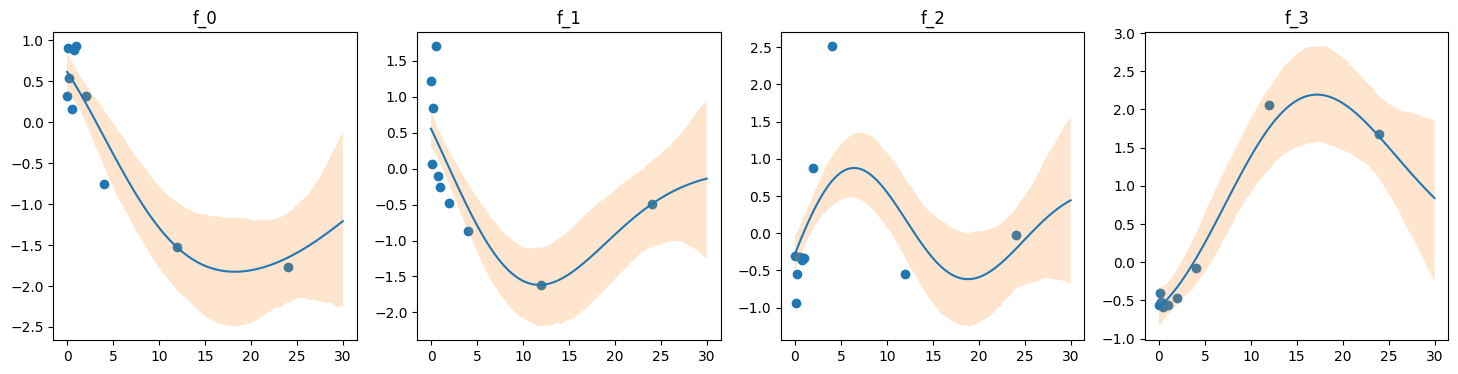

In [46]:
model.fit_and_set_f_prior_params(timepoints=timepoints, proportions=proportions, hypers=model.hypers_init_vals)
eval_timepoints = torch.linspace(0, 30, 100).view(-1, 1)
fig, ax = plt.subplots(1, n_cell_types, figsize=(18, 4))

n_samples = 1000
n_eval_timepoints = eval_timepoints.shape[0]
f_prior_np = model.sample_f_prior(eval_timepoints, n_samples=n_samples)
for cell_type_idx in range(n_cell_types):
    eval_timepoints_np = eval_timepoints.detach().numpy()
    f_prior_cell_type_np = f_prior_np[:, cell_type_idx, :].detach().numpy()
    assert f_prior_cell_type_np.shape == (n_samples, n_eval_timepoints)

    mean = f_prior_cell_type_np.mean(axis=0)
    upper = np.percentile(f_prior_cell_type_np, 97.5, axis=0)
    lower = np.percentile(f_prior_cell_type_np, 2.5, axis=0)
    ax[cell_type_idx].scatter(timepoints, proportions[:, cell_type_idx].flatten().detach().numpy(), label=f'f_{cell_type_idx}')
    ax[cell_type_idx].plot(eval_timepoints_np, mean, label=f'f_{cell_type_idx}')
    ax[cell_type_idx].fill_between(eval_timepoints_np.flatten(), lower, upper, alpha=0.2)

    ax[cell_type_idx].set_title(f'f_{cell_type_idx}')


In [49]:
model.fit(timepoints, proportions, n_iter=1000000, lr=0.00001, guide="MultivariateNormalFactorized")

[iteration 0001] loss: 2351.0696
[iteration 0101] loss: 1342.0853
[iteration 0201] loss: 1201.0631
[iteration 0301] loss: 1157.0172
[iteration 0401] loss: 1065.8634
[iteration 0501] loss: 1044.6394
[iteration 0601] loss: 1013.6732
[iteration 0701] loss: 960.3783
[iteration 0801] loss: 961.6272
[iteration 0901] loss: 921.2675
[iteration 1001] loss: 921.7848
[iteration 1101] loss: 911.0865
[iteration 1201] loss: 895.2100
[iteration 1301] loss: 865.2622
[iteration 1401] loss: 843.7811
[iteration 1501] loss: 862.4770
[iteration 1601] loss: 856.7093
[iteration 1701] loss: 823.2979
[iteration 1801] loss: 809.3489
[iteration 1901] loss: 806.5142
[iteration 2001] loss: 790.5128
[iteration 2101] loss: 801.7797
[iteration 2201] loss: 785.5703
[iteration 2301] loss: 796.2842
[iteration 2401] loss: 779.5585
[iteration 2501] loss: 761.8988
[iteration 2601] loss: 760.1691
[iteration 2701] loss: 770.7158
[iteration 2801] loss: 768.8812
[iteration 2901] loss: 763.4038
[iteration 3001] loss: 751.3748
[

KeyboardInterrupt: 

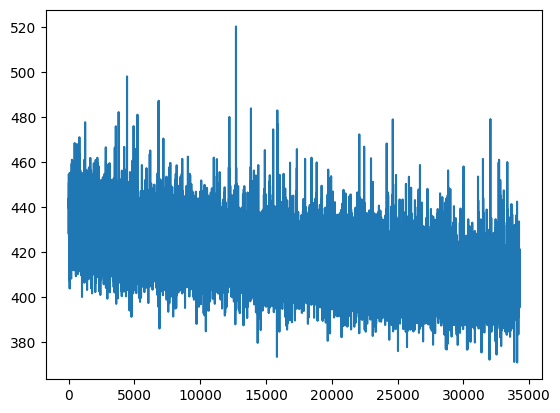

In [52]:
start = 40000
plt.plot((model.losses[start:]))

In [53]:
y = model.sample_observed_proportions(n_samples=1000).detach()

Text(0.5, 1.05, 'DIISCO posterior samples')

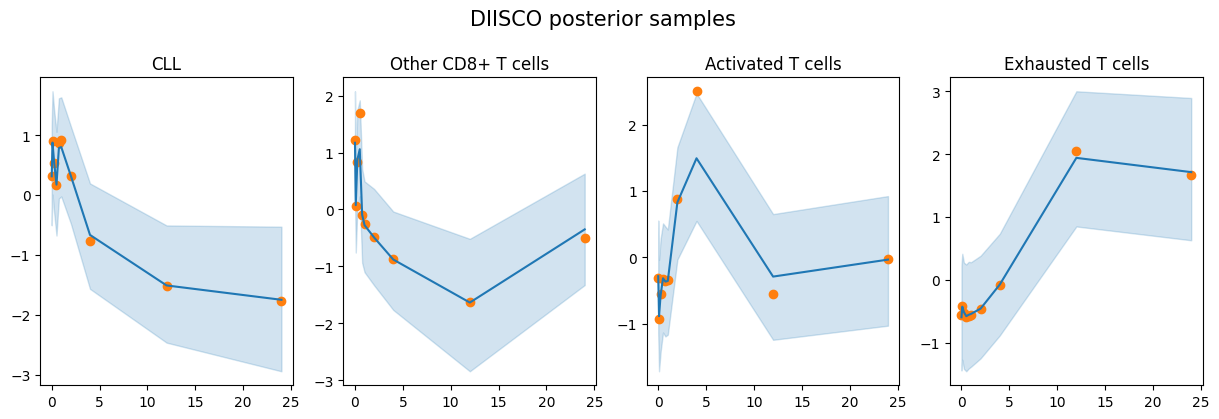

In [54]:
fig, axes = plt.subplots(1, n_cell_types, figsize=(15, 4))
for i in range(n_cell_types):
    cell_type_samples = y[:, :, i]
    mean = cell_type_samples.mean(axis=0)
    percentile_75 = np.percentile(cell_type_samples, 95, axis=0)
    percentile_25 = np.percentile(cell_type_samples, 5, axis=0)
    axes[i].plot(timepoints, mean, c='tab:blue')
    axes[i].fill_between(timepoints.squeeze(), percentile_25, percentile_75, color='tab:blue', alpha=0.2)
    axes[i].scatter(timepoints, proportions[:, i], c='tab:orange')
    axes[i].set_title(cell_types[i])

plt.suptitle('DIISCO posterior samples', fontsize=15, y=1.05)


In [76]:
predict_timepoints = torch.linspace(timepoints.min(), timepoints.max(), 100).reshape(-1, 1)
y_samples_predict = model.sample(predict_timepoints, n_samples=2000, sample_reuse_rate=10)
y_samples_predict = y_samples_predict[names.Y]

print(y_samples_predict.shape)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:07<00:00, 283.62it/s]


key:  W samples[key].shape:  torch.Size([10, 100, 4, 4])
len samples[key]:  200
key:  F samples[key].shape:  torch.Size([10, 100, 4, 1])
len samples[key]:  200
key:  Y samples[key].shape:  torch.Size([10, 100, 4])
len samples[key]:  200
torch.Size([2000, 100, 4])


Text(0.5, 1.05, 'DIISCO posterior samples')

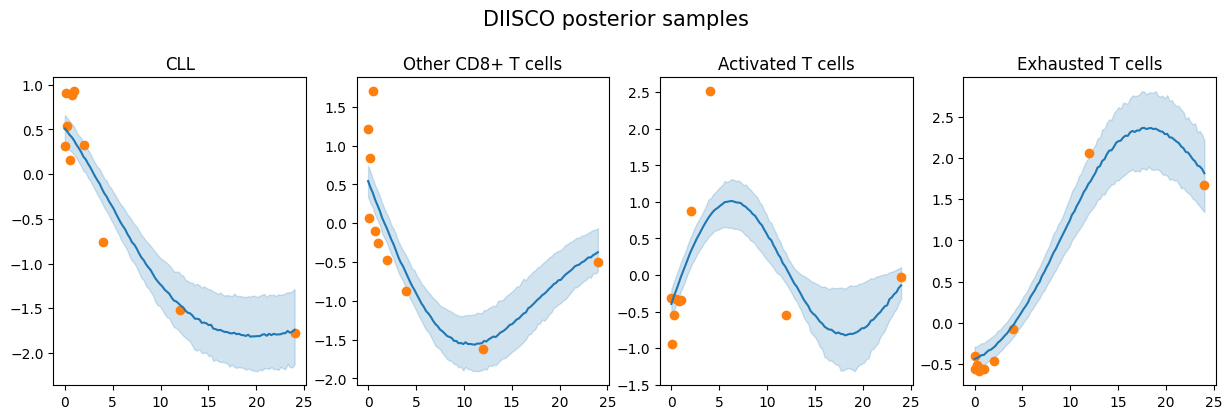

In [77]:
fig, axes = plt.subplots(1, n_cell_types, figsize=(15, 4))
for i in range(n_cell_types):
    cell_type_samples = y_samples_predict[:, :, i]
    mean = cell_type_samples.mean(axis=0)

    x = predict_timepoints.squeeze().numpy()
    percentile_75 = np.percentile(cell_type_samples, 75, axis=0)
    percentile_25 = np.percentile(cell_type_samples, 25, axis=0)

    axes[i].plot(x, mean, c='tab:blue')
    axes[i].fill_between(x, percentile_25, percentile_75, color='tab:blue', alpha=0.2)
    axes[i].scatter(timepoints, proportions[:, i], c='tab:orange')
    axes[i].set_title(df.columns[i])

plt.suptitle('DIISCO posterior samples', fontsize=15, y=1.05)


In [ ]:
learned_W = model.get_W_mean(n_samples=1000)
num_cols = 2
num_rows = int(np.ceil(n_timepoints / num_cols))

fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))
for timepoint_idx in range(n_timepoints):
    row_idx = timepoint_idx // num_cols
    col_idx = timepoint_idx % num_cols
    # Set colors to red and blue centered on 0 
    ax[row_idx, col_idx].imshow(learned_W[timepoint_idx, :, :].detach().numpy(), cmap='RdBu', vmin=-1, vmax=1)
    ax[row_idx, col_idx].set_title(f'W_{timepoint_idx}')
    # Add the numerical value of the W matrix
    for i in range(learned_W.shape[1]):
        for j in range(learned_W.shape[2]):
            text = ax[row_idx, col_idx].text(j, i, round(learned_W[timepoint_idx, i, j].item(), 2),
                                       ha="center", va="center", color="w")

    # Add the names from the cell types
    ax[row_idx, col_idx].set_xticks(np.arange(len(cell_types)))
    ax[row_idx, col_idx].set_yticks(np.arange(len(cell_types)))
    ax[row_idx, col_idx].set_xticklabels(cell_types)
    ax[row_idx, col_idx].set_yticklabels(cell_types)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[row_idx, col_idx].get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")
    
    
    


plt.suptitle('Learned W', fontsize=15, y=1.05)
plt.tight_layout()

In [ ]:
# Plot the W values through time 
fig, ax = plt.subplots(figsize=(20, 20))
for i in range(n_cell_types):
    for j in range(n_cell_types):
        name = 'output:'+ cell_types[i] + " input:" + cell_types[j]
        ax.plot(learned_W[:, i, j].detach().numpy(), label=f'W_{i}{j} {name}')
        
ax.set_title('W values through time')
ax.legend()

In [ ]:
learned_W = model.get_W_mean(n_samples=100)
learned_W_avg = learned_W.mean(axis=0)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
# Show images
plt.imshow(learned_W_avg.detach().numpy(), cmap='RdBu', vmin=-1, vmax=1)
# Add the numerical value of the W matrix
for i in range(learned_W_avg.shape[0]):
    for j in range(learned_W_avg.shape[1]):
        text = ax.text(j, i, round(learned_W_avg[i, j].item(), 5),
                   ha="center", va="center", color="w")
# Add the names from the cell types
ax.set_xticks(np.arange(len(cell_types)))
ax.set_yticks(np.arange(len(cell_types)))
ax.set_xticklabels(cell_types)
ax.set_yticklabels(cell_types)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor") 

    




In [ ]:
# Here we compared the learned latent proportions to the true latent proportions
f_mean = model.get_f_mean(n_samples=100)
f_mean = f_mean.detach().numpy()
f_true = proportions.detach().numpy()
assert f_mean.shape == f_true.shape
assert f_mean.shape == (n_timepoints, n_cell_types)

fig, ax =  plt.subplots(1, n_cell_types, figsize=(15, 4))
for cell_type_idx in range(n_cell_types):
    timepoints_np = timepoints.squeeze().numpy()
    ax[cell_type_idx].scatter(timepoints_np, f_true[:, cell_type_idx], c='tab:orange', label='True')
    ax[cell_type_idx].scatter(timepoints_np, f_mean[:, cell_type_idx], c='tab:blue', label='Learned')

    ax[cell_type_idx].plot(timepoints_np, f_true[:, cell_type_idx], c='tab:orange')
    ax[cell_type_idx].plot(timepoints_np, f_mean[:, cell_type_idx], c='tab:blue')

    ax[cell_type_idx].set_title(cell_types[cell_type_idx])
    ax[cell_type_idx].set_xlabel('Time')
    ax[cell_type_idx].set_ylabel('Normalize Proportion')
    ax[cell_type_idx].legend()
    


# Older Model

In [ ]:
x_gp = torch.linspace(timepoints.min(), timepoints.max(), 200).reshape(-1, 1)
y_gp = torch.sin(x_gp) + 0.1 * torch.randn(x_gp.shape)

plt.scatter(x_gp, y_gp)

In [ ]:
from diisco.gaussian_process import GaussianProcessRegressor
from functools import partial
from diisco.math_ops import rbf_kernel

kernel = partial(rbf_kernel, length_scale=1, variance=0.1)
regressor = GaussianProcessRegressor(kernel=kernel)
regressor.fit(x_gp, y_gp)

x_test_gp = torch.linspace(timepoints.min(), timepoints.max(), 1000).reshape(-1, 1)
y_test_gp, y_test_std = regressor.predict(x_test_gp)
plt.plot(x_test_gp, y_test_gp)

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(res['nelbos'][1:])
plt.xlabel('Epochs')
plt.ylabel('nelbos loss', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(res['nrmse'][1:])
plt.xlabel('Epochs')
plt.ylabel('nrmse', fontsize=14)

plt.suptitle('GPRN training loss', fontsize=14)

Compare GPRN latent functions $f_i$'s vs $f_i$ priors

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    f_pred = res['f_mu'][var]
    plt.figure(figsize=(18, 4))
    plt.suptitle('GPRN latent functions $f_i$\'s vs $f_i$ priors', fontsize=15, y=1.05)
    for i, f_i in enumerate(f_priors):
        plt.subplot(1, 4, i+1)
        plt.plot(X.flatten(), f_i, c='tab:blue', label='Prior')
        plt.plot(X_test.flatten(), f_pred[:, i].flatten(), c='tab:red', label='GPRN posterior')
        plt.title(f'$f_{i+1}$ ({cell_types[i]})', fontsize=14)
        plt.legend(loc='lower right', fontsize=12)

interact(update, var=int_slider)

Compare GPRN predictions $y$ vs actual

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    y_preds = res['Y_pred'][var]
    plt.figure(figsize=(18, 4))
    for i, y_i in enumerate(Y.T):
        plt.subplot(1, 4, i+1)
        plt.scatter(X.flatten(), Y_uncentered.T[i], s=15)
        y_i_preds = y_preds[:, i]
        y_i_preds_uncentered = y_i_preds + cell_type_means[i]
        plt.plot(X_test.flatten(), y_i_preds_uncentered, c='tab:red')
        plt.title(f'{df.columns[i]}', fontsize=14)
        if i==0: plt.ylabel('Proportion', fontsize=12)
        plt.ylim([0, 1])
    plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

interact(update, var=int_slider)

In [ ]:
y_samples, W_samples = model.eval_test_post()

plt.figure(figsize=(18, 4))
for i in range(y_samples.shape[2]):
    plt.subplot(1, 4, i+1)
    for sample in y_samples[:100, :, i]:
        plt.scatter(X_test.flatten(), sample, c='tab:red', s=0.5)
    y_samples_95_percentile = np.percentile(y_samples[:, :, i], 90, axis=0)
    y_samples_5_percentile = np.percentile(y_samples[:, :, i], 10, axis=0)
    plt.plot(X_test.flatten(), y_samples_95_percentile, c='tab:blue', label='90th percentile')
    plt.plot(X_test.flatten(), y_samples_5_percentile, c='tab:green', label='10th percentile')
    plt.title(f'{df.columns[i]}', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
#     plt.ylim([-0.5, 0.5])
plt.suptitle('GPRN posterior samples', fontsize=15, y=1.05)

In [ ]:
epoch_index = 5
y_preds = res['Y_pred'][epoch_index]

cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    plt.subplot(1, 4, i+1)
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1], s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds + cell_type_means[i]
    plt.plot(X_test.flatten(), y_i_preds_uncentered, c=cell_type_color[i][1])
    y_samples_75_percentile = np.percentile(y_samples[:, :, i], 75, axis=0)
    y_samples_75_percentile_uncentered = y_samples_75_percentile + cell_type_means[i]
    y_samples_25_percentile = np.percentile(y_samples[:, :, i], 25, axis=0)
    y_samples_25_percentile_uncentered = y_samples_25_percentile + cell_type_means[i]
    plt.fill_between(X_test.flatten(), y_samples_25_percentile_uncentered, 
                     y_samples_75_percentile_uncentered, 
                     color=cell_type_color[i][1], alpha=0.2)
    plt.title(f'{cell_type_color[i][0]} proportion', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.ylim([0, 1.0])
plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

In [ ]:
epoch_index = 5
y_preds = res['Y_pred'][epoch_index]

plt.figure(figsize=(9, 6))
for i, cell_type in enumerate(cell_types):
    plt.scatter(X.flatten(), Y_uncentered.T[i], label=cell_type, s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds + cell_type_means[i]
    plt.plot(X_test.flatten(), y_i_preds_uncentered)
    y_samples_75_percentile = np.percentile(y_samples[:, :, i], 75, axis=0)
    y_samples_75_percentile_uncentered = y_samples_75_percentile + cell_type_means[i]
    y_samples_25_percentile = np.percentile(y_samples[:, :, i], 25, axis=0)
    y_samples_25_percentile_uncentered = y_samples_25_percentile + cell_type_means[i]
    plt.fill_between(X_test.flatten(), y_samples_25_percentile_uncentered, 
                     y_samples_75_percentile_uncentered, 
                     color=cell_type_color[i][1], alpha=0.2)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.ylim([-1.5, 2])
plt.title('Proportion of cells over time by cell type', fontsize=14)

In [ ]:
epoch_index = 5
W = res['W_mu'][epoch_index]
W_avg_over_time = np.mean(W, axis=0)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmin=-1, vmax=1)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$', fontsize=14)

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    W = res['W_mu'][var]
    heatmap_vmin = res['W_mu'].min()
    heatmap_vmax = res['W_mu'].max()
    W_avg_over_time = np.mean(W, axis=0)
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}_{avg}$' + f' at epoch {var}', fontsize=15)

interact(update, var=int_slider)

Interpretation: $W_{i, j}$ is the effect of the $j^{th}$ latent function on the $i^{th }$ cell type.

In [ ]:
epoch_index = 5
W = res['W_mu'][epoch_index]
heatmap_vmin = W.min()
heatmap_vmax = W.max()

int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=99, step=1,
    description='time'
)

def update(var):
    W_at_time = W[var]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ax = sns.heatmap(W_at_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}$', fontsize=14)
    plt.subplot(1, 2, 2)
    y_preds = res['Y_pred'][epoch_index]
    for i, cell_type in enumerate(cell_types):
        plt.scatter(X.flatten(), df[cell_type], label=cell_type, s=15)
        plt.plot(X_test.flatten(), y_preds[:, i])
    plt.axvline(X_test.flatten()[var], c='tab:red', linestyle='--')
    plt.legend(loc='upper left', fontsize=11)
    plt.xticks(rotation=45)
    plt.ylim([-0.5, 0.5])
    plt.title('Proportion of cells over time by cell type', fontsize=13)

interact(update, var=int_slider)

In [ ]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', '-.', ':']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.plot(X_test.flatten(), W[:, i, j],
                 linestyle=linestyles[i],
                 label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.title('Cell type interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('time', fontsize=14)

In [ ]:
plt.figure(figsize=(18, 15))
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.subplot(4, 4, i*4 + j + 1)
        line = plt.plot(X_test.flatten(), W[:, i, j])
        W_i_j_samples = W_samples[:, :, i, j]
        W_samples_75_percentile = np.percentile(W_i_j_samples, 75, axis=0)
        W_samples_25_percentile = np.percentile(W_i_j_samples, 25, axis=0)
        plt.fill_between(X_test.flatten(), W_samples_25_percentile, W_samples_75_percentile, alpha=0.2)
        plt.ylabel('$W_{i, j}$', fontsize=14)
        plt.xlabel('time', fontsize=14)
        plt.ylim([-1, 1])
        plt.title('$W_{%s,%s}$ (%s - %s)' % (i, j, cell_type_i, cell_type_j),
                  fontsize=16)
plt.tight_layout()

## Experiment B (1:4 effector:target ratio)

In [ ]:
df = pd.read_csv('data/CAR-T ratios and umap/CARB_14_ratios_processed.pkl', index_col='Hours post co-culture')
df

In [ ]:
plt.figure(figsize=(8, 5))
cell_types = ['CLL', 'CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
for cell_type in cell_types:
    plt.plot(df[cell_type] * df['total_cells_per_sample'], label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Number of cells over time by cell type \n (cell type proportion * total_cells_per_sample)', 
          fontsize=12)

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper right', fontsize=12)
# plt.ylim([-0.5, 0.5])
plt.title('Proportion of cells over time by cell type', fontsize=14)

Center cell type proportions

In [ ]:
cell_type_means = df[cell_types].mean()
df[cell_types] -= cell_type_means
df

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Proportion (zero-centered) of cells over time by cell type', fontsize=14)

In [ ]:
# X = np.linspace(0, df.shape[0]-1, df.shape[0]).reshape(-1, 1)
X = df.index.values.reshape(-1, 1)
X[:3]

In [ ]:
Y = df[cell_types].values
Y

In [ ]:
# Sweep out timepoints between 0 and 24 to predict on
X_test = np.linspace(start=0, stop=df.index[-1], num=100).reshape(-1, 1)

# Placeholder Y_test just for the SGPRN API
Y_test = np.zeros((X_test.shape[0], Y.shape[1]))

# For plotting uncentered points
Y_uncentered = Y + cell_type_means.values

Add priors for $f_i$'s based on mean of independent GP fits

In [ ]:
f_priors = []
cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]
plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    rbf = RBF(1)
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.005, random_state=0)
    gpr.fit(X, y_i)
    y_pred = gpr.predict(X_test)
    f_priors.append(gpr.predict(X))
    plt.subplot(1, 4, i+1)
    plt.plot(X_test, y_pred + cell_type_means.values[i], c=cell_type_color[i][1])
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1])
    plt.title('$f_%s$ prior (%s)' % (i+1, cell_type_color[i][0]), fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
plt.suptitle('Independent GP fits to set $f_i$ priors', fontsize=15, y=1.05)
f_priors = np.array(f_priors)

Add regularization for $W$

In [ ]:
W_reg_lambdas = np.array([[ 10, 0.1, 0.1, 0.1], 
                          [0.1,  10, 0.1, 0.1], 
                          [0.1, 0.1,  10, 0.1], 
                          [0.1, 0.1, 0.1, 10]])

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_reg_lambdas, cmap="Reds", annot=True)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$W$ regularization penalty', fontsize=14)

In [ ]:
priors = {
    # f priors based on independent GP fits
    'F': f_priors.T.reshape(5, 4, 1),
#     'W': W_prior_mean,
#     'W_prior_min': W_prior_min,
#     'W_prior_max': W_prior_max,
    # default GPRN W prior
    'W': tf.Variable(0.001*tf.random.truncated_normal([5, 4, 4], mean=0, stddev=1.0), 
                     dtype=tf.float32),
    'W_reg_lambdas': W_reg_lambdas
}

In [ ]:
data = {
    'N_all': X.shape[0],
    'N_train': X.shape[0],
    'N_test': X.shape[0],
    'X_all': X,
    'Y_all': Y,
    'X_train': X,
    'X_test': X_test,
    'Y_train': Y,
    'Y_test': Y_test,
    'Y_mean': 0,
    'Y_std': 1,
    'Y_test_ground': Y,
    'DList': [4, 1, 1],
    'dname': 'None'
}

kernel = 'rbf'
f_kernel_bandwidth = 50
f_sigma = 0
W_kernel_bandwidth = 50
rank = 4
maxIter = 2500
interval = 100

cfg = {
    'data': data,
    'jitter': 1e-3,
    'init_std': 1e-3,
    'epochs': maxIter,
    'interval':interval,
    'alpha':1e-2,
    'ns': 100,
    'Q': rank,
    'kernel': kernel,
    'f_kernel_bandwidth': f_kernel_bandwidth,
    'f_sigma': f_sigma,
    'W_kernel_bandwidth': W_kernel_bandwidth
}

In [ ]:
model = SGPRN(cfg, init_type=priors)
res = model.fit()

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(res['nelbos'][1:])
plt.xlabel('Epochs')
plt.ylabel('nelbos loss', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(res['nrmse'][1:])
plt.xlabel('Epochs')
plt.ylabel('nrmse', fontsize=14)

plt.suptitle('GPRN training loss', fontsize=14)

Compare GPRN latent functions $f_i$'s vs $f_i$ priors

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    f_pred = res['f_mu'][var]
    plt.figure(figsize=(18, 4))
    plt.suptitle('GPRN latent functions $f_i$\'s vs $f_i$ priors', fontsize=15, y=1.05)
    for i, f_i in enumerate(f_priors):
        plt.subplot(1, 4, i+1)
        plt.plot(X.flatten(), f_i, c='tab:blue', label='Prior')
        plt.plot(X_test.flatten(), f_pred[:, i].flatten(), c='tab:red', label='GPRN posterior')
        plt.title(f'$f_{i+1}$ ({cell_types[i]})', fontsize=14)
        plt.legend(loc='lower right', fontsize=12)

interact(update, var=int_slider)

Compare GPRN predictions $y$ vs actual

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    y_preds = res['Y_pred'][var]
    plt.figure(figsize=(18, 4))
    for i, y_i in enumerate(Y.T):
        plt.subplot(1, 4, i+1)
        plt.scatter(X.flatten(), Y_uncentered.T[i], s=15)
        y_i_preds = y_preds[:, i]
        y_i_preds_uncentered = y_i_preds + cell_type_means[i]
        plt.plot(X_test.flatten(), y_i_preds_uncentered, c='tab:red')
        plt.title(f'{df.columns[i]}', fontsize=14)
        if i==0: plt.ylabel('Proportion', fontsize=12)
        plt.ylim([0, 1])
    plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

interact(update, var=int_slider)

In [ ]:
y_samples, W_samples = model.eval_test_post()

plt.figure(figsize=(18, 4))
for i in range(y_samples.shape[2]):
    plt.subplot(1, 4, i+1)
    for sample in y_samples[:100, :, i]:
        plt.scatter(X_test.flatten(), sample, c='tab:red', s=0.5)
    y_samples_95_percentile = np.percentile(y_samples[:, :, i], 90, axis=0)
    y_samples_5_percentile = np.percentile(y_samples[:, :, i], 10, axis=0)
    plt.plot(X_test.flatten(), y_samples_95_percentile, c='tab:blue', label='90th percentile')
    plt.plot(X_test.flatten(), y_samples_5_percentile, c='tab:green', label='10th percentile')
    plt.title(f'{df.columns[i]}', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
#     plt.ylim([-0.5, 0.5])
plt.suptitle('GPRN posterior samples', fontsize=15, y=1.05)

In [ ]:
epoch_index = 25
y_preds = res['Y_pred'][epoch_index]

cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    plt.subplot(1, 4, i+1)
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1], s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds + cell_type_means[i]
    plt.plot(X_test.flatten(), y_i_preds_uncentered, c=cell_type_color[i][1])
    y_samples_75_percentile = np.percentile(y_samples[:, :, i], 75, axis=0)
    y_samples_75_percentile_uncentered = y_samples_75_percentile + cell_type_means[i]
    y_samples_25_percentile = np.percentile(y_samples[:, :, i], 25, axis=0)
    y_samples_25_percentile_uncentered = y_samples_25_percentile + cell_type_means[i]
    plt.fill_between(X_test.flatten(), y_samples_25_percentile_uncentered, 
                     y_samples_75_percentile_uncentered, 
                     color=cell_type_color[i][1], alpha=0.2)
    plt.title(f'{cell_type_color[i][0]} proportion', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.ylim([-1.5, 2])
plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

In [ ]:
epoch_index = 25
y_preds = res['Y_pred'][epoch_index]

plt.figure(figsize=(9, 6))
for i, cell_type in enumerate(cell_types):
    plt.scatter(X.flatten(), Y_uncentered.T[i], label=cell_type, s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds + cell_type_means[i]
    plt.plot(X_test.flatten(), y_i_preds_uncentered)
    y_samples_75_percentile = np.percentile(y_samples[:, :, i], 75, axis=0)
    y_samples_75_percentile_uncentered = y_samples_75_percentile + cell_type_means[i]
    y_samples_25_percentile = np.percentile(y_samples[:, :, i], 25, axis=0)
    y_samples_25_percentile_uncentered = y_samples_25_percentile + cell_type_means[i]
    plt.fill_between(X_test.flatten(), y_samples_25_percentile_uncentered, 
                     y_samples_75_percentile_uncentered, 
                     color=cell_type_color[i][1], alpha=0.2)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.ylim([-1.5, 2])
plt.title('Proportion of cells over time by cell type', fontsize=14)

In [ ]:
epoch_index = 25
W = res['W_mu'][epoch_index]
W_avg_over_time = np.mean(W, axis=0)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmin=-1, vmax=1)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$', fontsize=14)

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    W = res['W_mu'][var]
    heatmap_vmin = res['W_mu'].min()
    heatmap_vmax = res['W_mu'].max()
    W_avg_over_time = np.mean(W, axis=0)
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}_{avg}$' + f' at epoch {var}', fontsize=15)

interact(update, var=int_slider)

Interpretation: $W_{i, j}$ is the effect of the $j^{th}$ latent function on the $i^{th }$ cell type.

In [ ]:
epoch_index = 25
W = res['W_mu'][epoch_index]
heatmap_vmin = W.min()
heatmap_vmax = W.max()

int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=99, step=1,
    description='time'
)

def update(var):
    W_at_time = W[var]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ax = sns.heatmap(W_at_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}$', fontsize=14)
    plt.subplot(1, 2, 2)
    y_preds = res['Y_pred'][epoch_index]
    for i, cell_type in enumerate(cell_types):
        plt.scatter(X.flatten(), df[cell_type], label=cell_type, s=15)
        plt.plot(X_test.flatten(), y_preds[:, i])
    plt.axvline(X_test.flatten()[var], c='tab:red', linestyle='--')
    plt.legend(loc='upper left', fontsize=11)
    plt.xticks(rotation=45)
    plt.ylim([-0.5, 0.5])
    plt.title('Proportion of cells over time by cell type', fontsize=13)

interact(update, var=int_slider)

In [ ]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', '-.', ':']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.plot(X_test.flatten(), W[:, i, j],
                 linestyle=linestyles[i],
                 label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.title('Cell type interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('time', fontsize=14)

In [ ]:
plt.figure(figsize=(18, 15))
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.subplot(4, 4, i*4 + j + 1)
        line = plt.plot(X_test.flatten(), W[:, i, j])
        W_i_j_samples = W_samples[:, :, i, j]
        W_samples_75_percentile = np.percentile(W_i_j_samples, 75, axis=0)
        W_samples_25_percentile = np.percentile(W_i_j_samples, 25, axis=0)
        plt.fill_between(X_test.flatten(), W_samples_25_percentile, W_samples_75_percentile, alpha=0.2)
        plt.ylabel('$W_{i, j}$', fontsize=14)
        plt.xlabel('time', fontsize=14)
        plt.ylim([-1, 1])
        plt.title('$W_{%s,%s}$ (%s - %s)' % (i, j, cell_type_i, cell_type_j),
                  fontsize=16)
plt.tight_layout()

## Experiment B (4:1 effector:target ratio)

In [ ]:
df = pd.read_csv('data/CAR-T ratios and umap/CARB_41_ratios_processed.pkl', index_col='Hours post co-culture')
df

In [ ]:
plt.figure(figsize=(8, 5))
cell_types = ['CLL', 'CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
for cell_type in cell_types:
    plt.plot(df[cell_type] * df['total_cells_per_sample'], label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Number of cells over time by cell type \n (cell type proportion * total_cells_per_sample)', 
          fontsize=12)

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper right', fontsize=12)
# plt.ylim([-0.5, 0.5])
plt.title('Proportion of cells over time by cell type', fontsize=14)

Center cell type proportions

In [ ]:
cell_type_means = df[cell_types].mean()
df[cell_types] -= cell_type_means
df

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Proportion (zero-centered) of cells over time by cell type', fontsize=14)

In [ ]:
# X = np.linspace(0, df.shape[0]-1, df.shape[0]).reshape(-1, 1)
X = df.index.values.reshape(-1, 1)
X[:3]

In [ ]:
Y = df[cell_types].values
Y

In [ ]:
# Sweep out timepoints between 0 and 24 to predict on
X_test = np.linspace(start=0, stop=df.index[-1], num=100).reshape(-1, 1)

# Placeholder Y_test just for the SGPRN API
Y_test = np.zeros((X_test.shape[0], Y.shape[1]))

# For plotting uncentered points
Y_uncentered = Y + cell_type_means.values

Add priors for $f_i$'s based on mean of independent GP fits

In [ ]:
f_priors = []
cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]
plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    rbf = RBF(1)
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.005, random_state=0)
    gpr.fit(X, y_i)
    y_pred = gpr.predict(X_test)
    f_priors.append(gpr.predict(X))
    plt.subplot(1, 4, i+1)
    plt.plot(X_test, y_pred + cell_type_means.values[i], c=cell_type_color[i][1])
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1])
    plt.title('$f_%s$ prior (%s)' % (i+1, cell_type_color[i][0]), fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
plt.suptitle('Independent GP fits to set $f_i$ priors', fontsize=15, y=1.05)
f_priors = np.array(f_priors)

Add regularization for $W$

In [ ]:
W_reg_lambdas = np.array([[ 10, 0.1, 0.1, 0.1], 
                          [0.1,  10, 0.1, 0.1], 
                          [0.1, 0.1,  10, 0.1], 
                          [0.1, 0.1, 0.1, 10]])

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_reg_lambdas, cmap="Reds", annot=True)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$W$ regularization penalty', fontsize=14)

In [ ]:
priors = {
    # f priors based on independent GP fits
    'F': f_priors.T.reshape(5, 4, 1),
#     'W': W_prior_mean,
#     'W_prior_min': W_prior_min,
#     'W_prior_max': W_prior_max,
    # default GPRN W prior
    'W': tf.Variable(0.001*tf.random.truncated_normal([5, 4, 4], mean=0, stddev=1.0), 
                     dtype=tf.float32),
    'W_reg_lambdas': W_reg_lambdas
}

In [ ]:
data = {
    'N_all': X.shape[0],
    'N_train': X.shape[0],
    'N_test': X.shape[0],
    'X_all': X,
    'Y_all': Y,
    'X_train': X,
    'X_test': X_test,
    'Y_train': Y,
    'Y_test': Y_test,
    'Y_mean': 0,
    'Y_std': 1,
    'Y_test_ground': Y,
    'DList': [4, 1, 1],
    'dname': 'None'
}

kernel = 'rbf'
f_kernel_bandwidth = 50
f_sigma = 0
W_kernel_bandwidth = 50
rank = 4
maxIter = 1500
interval = 100

cfg = {
    'data': data,
    'jitter': 1e-3,
    'init_std': 1e-3,
    'epochs': maxIter,
    'interval':interval,
    'alpha':1e-2,
    'ns': 100,
    'Q': rank,
    'kernel': kernel,
    'f_kernel_bandwidth': f_kernel_bandwidth,
    'f_sigma': f_sigma,
    'W_kernel_bandwidth': W_kernel_bandwidth
}

In [ ]:
model = SGPRN(cfg, init_type=priors)
res = model.fit()

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(res['nelbos'][1:])
plt.xlabel('Epochs')
plt.ylabel('nelbos loss', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(res['nrmse'][1:])
plt.xlabel('Epochs')
plt.ylabel('nrmse', fontsize=14)

plt.suptitle('GPRN training loss', fontsize=14)

Compare GPRN latent functions $f_i$'s vs $f_i$ priors

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    f_pred = res['f_mu'][var]
    plt.figure(figsize=(18, 4))
    plt.suptitle('GPRN latent functions $f_i$\'s vs $f_i$ priors', fontsize=15, y=1.05)
    for i, f_i in enumerate(f_priors):
        plt.subplot(1, 4, i+1)
        plt.plot(X.flatten(), f_i, c='tab:blue', label='Prior')
        plt.plot(X_test.flatten(), f_pred[:, i].flatten(), c='tab:red', label='GPRN posterior')
        plt.title(f'$f_{i+1}$ ({cell_types[i]})', fontsize=14)
        plt.legend(loc='lower right', fontsize=12)

interact(update, var=int_slider)

Compare GPRN predictions $y$ vs actual

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    y_preds = res['Y_pred'][var]
    plt.figure(figsize=(18, 4))
    for i, y_i in enumerate(Y.T):
        plt.subplot(1, 4, i+1)
        plt.scatter(X.flatten(), Y_uncentered.T[i], s=15)
        y_i_preds = y_preds[:, i]
        y_i_preds_uncentered = y_i_preds + cell_type_means[i]
        plt.plot(X_test.flatten(), y_i_preds_uncentered, c='tab:red')
        plt.title(f'{df.columns[i]}', fontsize=14)
        if i==0: plt.ylabel('Proportion', fontsize=12)
        plt.ylim([0, 1])
    plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

interact(update, var=int_slider)

In [ ]:
y_samples, W_samples = model.eval_test_post()

plt.figure(figsize=(18, 4))
for i in range(y_samples.shape[2]):
    plt.subplot(1, 4, i+1)
    for sample in y_samples[:100, :, i]:
        plt.scatter(X_test.flatten(), sample, c='tab:red', s=0.5)
    y_samples_95_percentile = np.percentile(y_samples[:, :, i], 90, axis=0)
    y_samples_5_percentile = np.percentile(y_samples[:, :, i], 10, axis=0)
    plt.plot(X_test.flatten(), y_samples_95_percentile, c='tab:blue', label='90th percentile')
    plt.plot(X_test.flatten(), y_samples_5_percentile, c='tab:green', label='10th percentile')
    plt.title(f'{df.columns[i]}', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
#     plt.ylim([-0.5, 0.5])
plt.suptitle('GPRN posterior samples', fontsize=15, y=1.05)

In [ ]:
epoch_index = 15
y_preds = res['Y_pred'][epoch_index]

cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    plt.subplot(1, 4, i+1)
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1], s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds + cell_type_means[i]
    plt.plot(X_test.flatten(), y_i_preds_uncentered, c=cell_type_color[i][1])
    y_samples_75_percentile = np.percentile(y_samples[:, :, i], 75, axis=0)
    y_samples_75_percentile_uncentered = y_samples_75_percentile + cell_type_means[i]
    y_samples_25_percentile = np.percentile(y_samples[:, :, i], 25, axis=0)
    y_samples_25_percentile_uncentered = y_samples_25_percentile + cell_type_means[i]
    plt.fill_between(X_test.flatten(), y_samples_25_percentile_uncentered, 
                     y_samples_75_percentile_uncentered, 
                     color=cell_type_color[i][1], alpha=0.2)
    plt.title(f'{cell_type_color[i][0]} proportion', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.ylim([-1.5, 2])
plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

In [ ]:
epoch_index = 15
y_preds = res['Y_pred'][epoch_index]

plt.figure(figsize=(9, 6))
for i, cell_type in enumerate(cell_types):
    plt.scatter(X.flatten(), Y_uncentered.T[i], label=cell_type, s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds + cell_type_means[i]
    plt.plot(X_test.flatten(), y_i_preds_uncentered)
    y_samples_75_percentile = np.percentile(y_samples[:, :, i], 75, axis=0)
    y_samples_75_percentile_uncentered = y_samples_75_percentile + cell_type_means[i]
    y_samples_25_percentile = np.percentile(y_samples[:, :, i], 25, axis=0)
    y_samples_25_percentile_uncentered = y_samples_25_percentile + cell_type_means[i]
    plt.fill_between(X_test.flatten(), y_samples_25_percentile_uncentered, 
                     y_samples_75_percentile_uncentered, 
                     color=cell_type_color[i][1], alpha=0.2)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.ylim([-1.5, 2])
plt.title('Proportion of cells over time by cell type', fontsize=14)

In [ ]:
epoch_index = 15
W = res['W_mu'][epoch_index]
W_avg_over_time = np.mean(W, axis=0)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmin=-1, vmax=1)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$', fontsize=14)

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    W = res['W_mu'][var]
    heatmap_vmin = res['W_mu'].min()
    heatmap_vmax = res['W_mu'].max()
    W_avg_over_time = np.mean(W, axis=0)
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}_{avg}$' + f' at epoch {var}', fontsize=15)

interact(update, var=int_slider)

Interpretation: $W_{i, j}$ is the effect of the $j^{th}$ latent function on the $i^{th }$ cell type.

In [ ]:
epoch_index = 15
W = res['W_mu'][epoch_index]
heatmap_vmin = W.min()
heatmap_vmax = W.max()

int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=99, step=1,
    description='time'
)

def update(var):
    W_at_time = W[var]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ax = sns.heatmap(W_at_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}$', fontsize=14)
    plt.subplot(1, 2, 2)
    y_preds = res['Y_pred'][epoch_index]
    for i, cell_type in enumerate(cell_types):
        plt.scatter(X.flatten(), df[cell_type], label=cell_type, s=15)
        plt.plot(X_test.flatten(), y_preds[:, i])
    plt.axvline(X_test.flatten()[var], c='tab:red', linestyle='--')
    plt.legend(loc='upper left', fontsize=11)
    plt.xticks(rotation=45)
    plt.ylim([-0.5, 0.5])
    plt.title('Proportion of cells over time by cell type', fontsize=13)

interact(update, var=int_slider)

In [ ]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', '-.', ':']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.plot(X_test.flatten(), W[:, i, j],
                 linestyle=linestyles[i],
                 label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.title('Cell type interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('time', fontsize=14)

In [ ]:
plt.figure(figsize=(18, 15))
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.subplot(4, 4, i*4 + j + 1)
        line = plt.plot(X_test.flatten(), W[:, i, j])
        W_i_j_samples = W_samples[:, :, i, j]
        W_samples_75_percentile = np.percentile(W_i_j_samples, 75, axis=0)
        W_samples_25_percentile = np.percentile(W_i_j_samples, 25, axis=0)
        plt.fill_between(X_test.flatten(), W_samples_25_percentile, W_samples_75_percentile, alpha=0.2)
        plt.ylabel('$W_{i, j}$', fontsize=14)
        plt.xlabel('time', fontsize=14)
        plt.ylim([-1, 1])
        plt.title('$W_{%s,%s}$ (%s - %s)' % (i, j, cell_type_i, cell_type_j),
                  fontsize=16)
plt.tight_layout()

## Experiment C

In [ ]:
df = pd.read_csv('data/CAR-T ratios and umap/CARC_ratios_processed.pkl', index_col='Hours post co-culture')
df.columns = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells',
              'total_cells_per_sample']
df

In [ ]:
plt.figure(figsize=(8, 5))
cell_types = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
for cell_type in cell_types:
    plt.plot(df[cell_type] * df['total_cells_per_sample'], label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Number of cells over time by cell type \n (cell type proportion * total_cells_per_sample)', 
          fontsize=12)

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper right', fontsize=12)
# plt.ylim([0, 1.0])
plt.title('Proportion of cells types over time', fontsize=14)
plt.xlabel('Hours post co-culture', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.savefig('figures/fig_2_cell_type_proportions.eps')

Center cell type proportions

In [ ]:
cell_type_means = df[cell_types].mean()
cell_type_std_devs = df[cell_types].std()
df[cell_types] -= cell_type_means
df[cell_types] /= cell_type_std_devs
df

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Proportions (z-scored) of cells over time by cell type', fontsize=14)

In [ ]:
# X = np.linspace(0, df.shape[0]-1, df.shape[0]).reshape(-1, 1)
X = df.index.values.reshape(-1, 1)
X[:3]

In [ ]:
Y = df[cell_types].values
Y

In [ ]:
# Sweep out timepoints between 0 and 24 to predict on
X_test = np.linspace(start=0, stop=df.index[-1], num=100).reshape(-1, 1)

# Placeholder Y_test just for the SGPRN API
Y_test = np.zeros((X_test.shape[0], Y.shape[1]))

# For plotting uncentered points
Y_uncentered = Y * cell_type_std_devs.values + cell_type_means.values

Add priors for $f_i$'s based on mean of independent GP fits

In [ ]:
f_priors = []
cell_type_color = [('MEC1 cells', 'tab:blue'), 
                   ('Other CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]
plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    rbf = RBF(length_scale=5, length_scale_bounds=(5, 5))
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.05, random_state=0)
    gpr.fit(X, y_i)
    y_pred = gpr.predict(X_test)
    f_priors.append(gpr.predict(X))
    y_pred_uncentered = y_pred * cell_type_std_devs.values[i] + cell_type_means.values[i]
    plt.subplot(1, 4, i+1)
    plt.plot(X_test, y_pred_uncentered, c=cell_type_color[i][1])
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1])
    plt.title('$f_%s$ latent (%s)' % (i+1, cell_type_color[i][0]), fontsize=14)
    plt.xlabel('Hours post co-culture', fontsize=12)
    if i==0: plt.ylabel('Proportion', fontsize=12)
plt.suptitle('Independent GP fits to set $f_i$ latent functions', fontsize=15, y=1.05)
f_priors = np.array(f_priors)

plt.savefig('figures/fig_2_indep_gp_fits_for_f.eps')

Add regularization for $W$

In [ ]:
W_reg_lambdas = np.ones((4, 4)) * 0.1
np.fill_diagonal(W_reg_lambdas, 10)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_reg_lambdas, cmap="Reds", annot=True)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$W$ regularization penalties', fontsize=14)
plt.savefig('figures/fig_2_W_reg_penalties.eps', bbox_inches = "tight")

In [ ]:
priors = {
    # f priors based on independent GP fits
    'F': f_priors.T.reshape(10, 4, 1),
#     'W': W_prior_mean,
#     'W_prior_min': W_prior_min,
#     'W_prior_max': W_prior_max,
    # default GPRN W prior
    'W': tf.Variable(0.001*tf.random.truncated_normal([10, 4, 4], mean=0, stddev=1.0), 
                     dtype=tf.float32),
    'W_reg_lambdas': W_reg_lambdas
}

In [ ]:
data = {
    'N_all': X.shape[0],
    'N_train': X.shape[0],
    'N_test': X.shape[0],
    'X_all': X,
    'Y_all': Y,
    'X_train': X,
    'X_test': X_test,
    'Y_train': Y,
    'Y_test': Y_test,
    'Y_mean': 0,
    'Y_std': 1,
    'Y_test_ground': Y,
    'DList': [4, 1, 1],
    'dname': 'None'
}

kernel = 'rbf'
f_kernel_bandwidth = 100
f_sigma = 0
W_kernel_bandwidth = 100
rank = 4
maxIter = 500
interval = 100

cfg = {
    'data': data,
    'jitter': 1e-3,
    'init_std': 1e-3,
    'epochs': maxIter,
    'interval':interval,
    'alpha':1e-2,
    'ns': 100,
    'Q': rank,
    'kernel': kernel,
    'f_kernel_bandwidth': f_kernel_bandwidth,
    'f_sigma': f_sigma,
    'W_kernel_bandwidth': W_kernel_bandwidth
}

In [ ]:
model = SGPRN(cfg, init_type=priors)
res = model.fit()

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(res['nelbos'][1:])
plt.xlabel('Epochs')
plt.ylabel('nelbos loss', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(res['nrmse'][1:])
plt.xlabel('Epochs')
plt.ylabel('nrmse', fontsize=14)

plt.suptitle('GPRN training loss', fontsize=14)

Compare GPRN latent functions $f_i$'s vs $f_i$ priors

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    f_pred = res['f_mu'][var]
    plt.figure(figsize=(18, 4))
    plt.suptitle('GPRN latent functions $f_i$\'s vs $f_i$ priors', fontsize=15, y=1.05)
    for i, f_i in enumerate(f_priors):
        plt.subplot(1, 4, i+1)
        plt.plot(X.flatten(), f_i, c='tab:blue', label='Prior')
        plt.plot(X_test.flatten(), f_pred[:, i].flatten(), c='tab:red', label='GPRN posterior')
        plt.title(f'$f_{i+1}$ ({cell_types[i]})', fontsize=14)
        plt.legend(loc='lower right', fontsize=12)

interact(update, var=int_slider)

Compare GPRN predictions $y$ vs actual

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    y_preds = res['Y_pred'][var]
    plt.figure(figsize=(18, 4))
    for i, y_i in enumerate(Y.T):
        plt.subplot(1, 4, i+1)
        plt.scatter(X.flatten(), Y_uncentered.T[i], s=15)
        y_i_preds = y_preds[:, i]
        y_i_preds_uncentered = y_i_preds  * cell_type_std_devs[i] + cell_type_means[i]
        plt.plot(X_test.flatten(), y_i_preds_uncentered, c='tab:red')
        plt.title(f'{df.columns[i]}', fontsize=14)
        if i==0: plt.ylabel('Proportion', fontsize=12)
        plt.ylim([0, 1])
    plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

interact(update, var=int_slider)

In [ ]:
y_samples, W_samples = model.eval_test_post()

plt.figure(figsize=(18, 4))
for i in range(y_samples.shape[2]):
    plt.subplot(1, 4, i+1)
    for sample in y_samples[:100, :, i]:
        plt.scatter(X_test.flatten(), sample, c='tab:red', s=0.5)
    y_samples_sd = np.std(y_samples[:, :, i], axis=0)
    y_samples_plus_1_sd = y_samples[:, :, i].mean(axis=0) + y_samples_sd
    y_samples_minus_1_sd = y_samples[:, :, i].mean(axis=0) - y_samples_sd
    plt.plot(X_test.flatten(), y_samples_plus_1_sd, c='tab:blue', label='+1 SD')
    plt.plot(X_test.flatten(), y_samples_minus_1_sd, c='tab:green', label='-1 SD')
    plt.title(f'{df.columns[i]}', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
plt.suptitle('GPRN posterior samples', fontsize=15, y=1.05)

In [ ]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors

epoch_index = res['W_mu'].shape[0]-1
y_preds = res['Y_pred'][epoch_index]

cell_type_color = [('MEC1 cells', 'tab:blue'), 
                   ('Other CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    ax = axes[i]
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds * cell_type_std_devs[i] + cell_type_means[i]
    y_i_preds_uncentered = np.clip(y_i_preds_uncentered, 0, 1)
    line = ax.plot(X_test.flatten(), y_i_preds_uncentered, c=cell_type_color[i][1])
    y_samples_sd = np.std(y_samples[:, :, i], axis=0)
    y_samples_plus_1_sd = y_samples[:, :, i].mean(axis=0) + y_samples_sd
    y_samples_minus_1_sd = y_samples[:, :, i].mean(axis=0) - y_samples_sd
    # Uncenter conf ints
    y_samples_plus_1_sd = y_samples_plus_1_sd * cell_type_std_devs[i] + cell_type_means[i]
    y_samples_minus_1_sd = y_samples_minus_1_sd * cell_type_std_devs[i] + cell_type_means[i]
    # Clip conf ints b/w 0 to 1
    y_samples_plus_1_sd = np.clip(y_samples_plus_1_sd, 0, 1)
    y_samples_minus_1_sd = np.clip(y_samples_minus_1_sd, 0, 1)
    color_with_alpha = list(colors.to_rgb(cell_type_color[i][1])) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    ax.fill_between(X_test.flatten(), y_samples_minus_1_sd, y_samples_plus_1_sd, 
                     color=color_without_alpha)
    ax.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1], s=15)
    ax.set_title(f'{cell_type_color[i][0]} proportion', fontsize=14)
    ax.set_xlabel('Hours post co-culture', fontsize=12)
    if i==0: ax.set_ylabel('Proportion', fontsize=12)
plt.suptitle('GPRN predictions', fontsize=15, y=1.05)

plt.savefig('figures/fig_2_gprn_predictions.eps')

In [ ]:
epoch_index = res['W_mu'].shape[0]-1
W = res['W_mu'][epoch_index]
W_avg_over_time = np.mean(W, axis=0)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmin=-1, vmax=1)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$', fontsize=14)

plt.savefig('figures/fig_2_W_avg.eps', bbox_inches='tight')

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    W = res['W_mu'][var]
    heatmap_vmin = res['W_mu'].min()
    heatmap_vmax = res['W_mu'].max()
    W_avg_over_time = np.mean(W, axis=0)
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}_{avg}$' + f' at epoch {var}', fontsize=15)

interact(update, var=int_slider)

Interpretation: $W_{i, j}$ is the effect of the $j^{th}$ latent function on the $i^{th }$ cell type.

In [ ]:
epoch_index = res['W_mu'].shape[0]-1
W = res['W_mu'][epoch_index]
heatmap_vmin = W.min()
heatmap_vmax = W.max()

int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=99, step=1,
    description='time'
)

def update(var):
    W_at_time = W[var]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ax = sns.heatmap(W_at_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}$', fontsize=14)
    plt.subplot(1, 2, 2)
    y_preds = res['Y_pred'][epoch_index]
    for i, cell_type in enumerate(cell_types):
        plt.scatter(X.flatten(), df[cell_type] * cell_type_std_devs[i] + cell_type_means[i], 
                    label=cell_type, s=15)
        plt.plot(X_test.flatten(), y_preds[:, i] * cell_type_std_devs[i] + cell_type_means[i])
    plt.axvline(X_test.flatten()[var], c='tab:red', linestyle='--')
    plt.legend(loc='upper left', fontsize=11)
    plt.xticks(rotation=45)
    plt.title('Proportion of cells over time by cell type', fontsize=13)

interact(update, var=int_slider)

In [ ]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', '-.', ':']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.plot(X_test.flatten(), W[:, i, j],
                 linestyle=linestyles[i],
                 label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.title('Cell type interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Hours post co-culture', fontsize=14)

plt.savefig('figures/fig_2_W_over_time.eps', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(18, 15))
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.subplot(4, 4, i*4 + j + 1)
        line = plt.plot(X_test.flatten(), W[:, i, j])
        W_i_j_samples = W_samples[:, :, i, j]
        W_samples_75_percentile = np.percentile(W_i_j_samples, 95, axis=0)
        W_samples_25_percentile = np.percentile(W_i_j_samples, 5, axis=0)
        color_with_alpha = list(colors.to_rgb('tab:blue')) + [0.2]
        color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
        plt.fill_between(X_test.flatten(), W_samples_25_percentile, W_samples_75_percentile, 
                         color=color_without_alpha)
        plt.ylabel('$W_{i, j}$', fontsize=14)
        plt.xlabel('Hours post co-culture', fontsize=14)
        plt.ylim([-1, 1])
        plt.title('$W_{%s,%s}$ (%s - %s)' % (i, j, cell_type_i, cell_type_j),
                  fontsize=14)
plt.tight_layout()

plt.savefig('figures/fig_S1_W_conf_int.eps', bbox_inches='tight')

In [ ]:
W_avg_edge_list = []

for row in range(W_avg_over_time.shape[0]):
    for col in range(W_avg_over_time.shape[0]):
        W_avg_edge_list.append({
            'Source cluster': cell_types[col],
            'Target cluster': cell_types[row],
            'Interaction weight': W_avg_over_time[row, col],
            'abs(Interaction weight)': np.abs(W_avg_over_time[row, col]),
            'sign(Interaction weight)': np.sign(W_avg_over_time[row, col])
        })
        
W_avg_edge_list_df = pd.DataFrame(W_avg_edge_list)
W_avg_edge_list_df.to_csv('data/CAR-T/W_avg_edge_list.csv')
W_avg_edge_list_df.head()

In [ ]:
y_preds = res['Y_pred'][epoch_index]
y_preds = y_preds * cell_type_std_devs.values + cell_type_means.values
y_preds = np.clip(y_preds, 0, 1)
y_preds_avg = y_preds.mean(axis=0)
y_preds_avg_df = pd.DataFrame(y_preds_avg, index=cell_types, 
                              columns=['Inferred cluster proportion'])
y_preds_avg_df.index.name = 'Cell type'
y_preds_avg_df.to_csv('data/CAR-T/predicted_cluster_props_avg.csv')
y_preds_avg_df

In [ ]:
for hours_post_coculture in range(21):
    hours_nearest_X_index = np.argmin(np.abs(X_test - hours_post_coculture))
    y_preds_df = pd.DataFrame(y_preds[hours_nearest_X_index], index=cell_types, 
                          columns=['Inferred cluster proportion'])
    y_preds_df.index.name = 'Cell type'
    y_preds_df.to_csv(f'data/CAR-T/predicted_cluster_props_over_time/predicted_cluster_props_{hours_post_coculture}.csv')
    

In [ ]:
W = res['W_mu'][epoch_index]
W_abs = np.abs(res['W_mu'][epoch_index])
W_min = W_abs.min()
W_max = W_abs.max()
W_abs_normalized = (W_abs - W_min) / (W_max - W_min) * 3 + 0.5

In [ ]:
for hours_post_coculture in range(21):
    hours_nearest_X_index = np.argmin(np.abs(X_test - hours_post_coculture))
    W_t = res['W_mu'][epoch_index][hours_nearest_X_index]
    W_t_avg_edge_list = []
    for row in range(W_t.shape[0]):
        for col in range(W_t.shape[0]):
            W_t_avg_edge_list.append({
                'Source cluster': cell_types[col],
                'Target cluster': cell_types[row],
                'Interaction weight': W_t[row, col],
                'abs(Interaction weight)': W_abs_normalized[hours_nearest_X_index, row, col],
                'sign(Interaction weight)': np.sign(W_t[row, col])
            })

    W_t_avg_edge_list_df = pd.DataFrame(W_t_avg_edge_list)
    W_t_avg_edge_list_df.to_csv(f'data/CAR-T/W_edge_list_over_time/W_edge_list_{hours_post_coculture}.csv')

In [ ]:
np.save('data/CAR-T/W.npy', W)
np.save('data/CAR-T/X_test.npy', X_test)

## Experiment D

In [ ]:
df = pd.read_csv('data/CAR-T ratios and umap/CARD_ratios_processed.pkl', index_col='Hours post co-culture')
df.columns = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells',
              'total_cells_per_sample']
df

In [ ]:
plt.figure(figsize=(8, 5))
cell_types = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
for cell_type in cell_types:
    plt.plot(df[cell_type] * df['total_cells_per_sample'], label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Number of cells over time by cell type \n (cell type proportion * total_cells_per_sample)', 
          fontsize=12)

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper right', fontsize=12)
plt.ylim([0, 1.0])
plt.title('Proportion of cells types over time', fontsize=14)
plt.xlabel('Hours post co-culture', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.savefig('figures/fig_2_cell_type_proportions.eps')

Center cell type proportions

In [ ]:
cell_type_means = df[cell_types].mean()
cell_type_std_devs = df[cell_types].std()
df[cell_types] -= cell_type_means
df[cell_types] /= cell_type_std_devs
df

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Proportions (z-scored) of cells over time by cell type', fontsize=14)

In [ ]:
# X = np.linspace(0, df.shape[0]-1, df.shape[0]).reshape(-1, 1)
X = df.index.values.reshape(-1, 1)
X[:3]

In [ ]:
Y = df[cell_types].values
Y

In [ ]:
# Sweep out timepoints between 0 and 24 to predict on
X_test = np.linspace(start=0, stop=df.index[-1], num=100).reshape(-1, 1)

# Placeholder Y_test just for the SGPRN API
Y_test = np.zeros((X_test.shape[0], Y.shape[1]))

# For plotting uncentered points
Y_uncentered = Y * cell_type_std_devs.values + cell_type_means.values

Add priors for $f_i$'s based on mean of independent GP fits

In [ ]:
f_priors = []
cell_type_color = [('MEC1 cells', 'tab:blue'), 
                   ('Other CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]
plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    rbf = RBF(length_scale=5, length_scale_bounds=(5, 5))
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.05, random_state=0)
    gpr.fit(X, y_i)
    y_pred = gpr.predict(X_test)
    f_priors.append(gpr.predict(X))
    y_pred_uncentered = y_pred * cell_type_std_devs.values[i] + cell_type_means.values[i]
    plt.subplot(1, 4, i+1)
    plt.plot(X_test, y_pred_uncentered, c=cell_type_color[i][1])
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1])
    plt.title('$f_%s$ latent (%s)' % (i+1, cell_type_color[i][0]), fontsize=14)
    plt.xlabel('Hours post co-culture', fontsize=12)
    if i==0: plt.ylabel('Proportion', fontsize=12)
plt.suptitle('Independent GP fits to set $f_i$ latent functions', fontsize=15, y=1.05)
f_priors = np.array(f_priors)

plt.savefig('figures/fig_2_indep_gp_fits_for_f.eps')

Add regularization for $W$

In [ ]:
W_reg_lambdas = np.ones((4, 4)) * 0.1
np.fill_diagonal(W_reg_lambdas, 10)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_reg_lambdas, cmap="Reds", annot=True)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$W$ regularization penalties', fontsize=14)
plt.savefig('figures/fig_2_W_reg_penalties.eps', bbox_inches = "tight")

In [ ]:
priors = {
    # f priors based on independent GP fits
    'F': f_priors.T.reshape(10, 4, 1),
#     'W': W_prior_mean,
#     'W_prior_min': W_prior_min,
#     'W_prior_max': W_prior_max,
    # default GPRN W prior
    'W': tf.Variable(0.001*tf.random.truncated_normal([10, 4, 4], mean=0, stddev=1.0), 
                     dtype=tf.float32),
    'W_reg_lambdas': W_reg_lambdas
}

In [ ]:
data = {
    'N_all': X.shape[0],
    'N_train': X.shape[0],
    'N_test': X.shape[0],
    'X_all': X,
    'Y_all': Y,
    'X_train': X,
    'X_test': X_test,
    'Y_train': Y,
    'Y_test': Y_test,
    'Y_mean': 0,
    'Y_std': 1,
    'Y_test_ground': Y,
    'DList': [4, 1, 1],
    'dname': 'None'
}

kernel = 'rbf'
f_kernel_bandwidth = 100
f_sigma = 0
W_kernel_bandwidth = 100
rank = 4
maxIter = 500
interval = 100

cfg = {
    'data': data,
    'jitter': 1e-3,
    'init_std': 1e-3,
    'epochs': maxIter,
    'interval':interval,
    'alpha':1e-2,
    'ns': 100,
    'Q': rank,
    'kernel': kernel,
    'f_kernel_bandwidth': f_kernel_bandwidth,
    'f_sigma': f_sigma,
    'W_kernel_bandwidth': W_kernel_bandwidth
}

In [ ]:
model = SGPRN(cfg, init_type=priors)
res = model.fit()

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(res['nelbos'][1:])
plt.xlabel('Epochs')
plt.ylabel('nelbos loss', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(res['nrmse'][1:])
plt.xlabel('Epochs')
plt.ylabel('nrmse', fontsize=14)

plt.suptitle('GPRN training loss', fontsize=14)

Compare GPRN latent functions $f_i$'s vs $f_i$ priors

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    f_pred = res['f_mu'][var]
    plt.figure(figsize=(18, 4))
    plt.suptitle('GPRN latent functions $f_i$\'s vs $f_i$ priors', fontsize=15, y=1.05)
    for i, f_i in enumerate(f_priors):
        plt.subplot(1, 4, i+1)
        plt.plot(X.flatten(), f_i, c='tab:blue', label='Prior')
        plt.plot(X_test.flatten(), f_pred[:, i].flatten(), c='tab:red', label='GPRN posterior')
        plt.title(f'$f_{i+1}$ ({cell_types[i]})', fontsize=14)
        plt.legend(loc='lower right', fontsize=12)

interact(update, var=int_slider)

Compare GPRN predictions $y$ vs actual

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    y_preds = res['Y_pred'][var]
    plt.figure(figsize=(18, 4))
    for i, y_i in enumerate(Y.T):
        plt.subplot(1, 4, i+1)
        plt.scatter(X.flatten(), Y_uncentered.T[i], s=15)
        y_i_preds = y_preds[:, i]
        y_i_preds_uncentered = y_i_preds  * cell_type_std_devs[i] + cell_type_means[i]
        plt.plot(X_test.flatten(), y_i_preds_uncentered, c='tab:red')
        plt.title(f'{df.columns[i]}', fontsize=14)
        if i==0: plt.ylabel('Proportion', fontsize=12)
        plt.ylim([0, 1])
    plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

interact(update, var=int_slider)

In [ ]:
y_samples, W_samples = model.eval_test_post()

plt.figure(figsize=(18, 4))
for i in range(y_samples.shape[2]):
    plt.subplot(1, 4, i+1)
    for sample in y_samples[:100, :, i]:
        plt.scatter(X_test.flatten(), sample, c='tab:red', s=0.5)
    y_samples_sd = np.std(y_samples[:, :, i], axis=0)
    y_samples_plus_1_sd = y_samples[:, :, i].mean(axis=0) + y_samples_sd
    y_samples_minus_1_sd = y_samples[:, :, i].mean(axis=0) - y_samples_sd
    plt.plot(X_test.flatten(), y_samples_plus_1_sd, c='tab:blue', label='+1 SD')
    plt.plot(X_test.flatten(), y_samples_minus_1_sd, c='tab:green', label='-1 SD')
    plt.title(f'{df.columns[i]}', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
plt.suptitle('GPRN posterior samples', fontsize=15, y=1.05)

In [ ]:
from mimic_alpha.mimic_alpha import colorAlpha_to_rgb
import matplotlib.colors as colors

epoch_index = res['W_mu'].shape[0]-1
y_preds = res['Y_pred'][epoch_index]

cell_type_color = [('MEC1 cells', 'tab:blue'), 
                   ('Other CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    ax = axes[i]
    ax.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1], s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds * cell_type_std_devs[i] + cell_type_means[i]
    y_i_preds_uncentered = np.clip(y_i_preds_uncentered, 0, 1)
    line = ax.plot(X_test.flatten(), y_i_preds_uncentered, c=cell_type_color[i][1])
    y_samples_sd = np.std(y_samples[:, :, i], axis=0)
    y_samples_plus_1_sd = y_samples[:, :, i].mean(axis=0) + y_samples_sd
    y_samples_minus_1_sd = y_samples[:, :, i].mean(axis=0) - y_samples_sd
    # Uncenter conf ints
    y_samples_plus_1_sd = y_samples_plus_1_sd * cell_type_std_devs[i] + cell_type_means[i]
    y_samples_minus_1_sd = y_samples_minus_1_sd * cell_type_std_devs[i] + cell_type_means[i]
    # Clip conf ints b/w 0 to 1
    y_samples_plus_1_sd = np.clip(y_samples_plus_1_sd, 0, 1)
    y_samples_minus_1_sd = np.clip(y_samples_minus_1_sd, 0, 1)
    color_with_alpha = list(colors.to_rgb(cell_type_color[i][1])) + [0.2]
    color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
    ax.fill_between(X_test.flatten(), y_samples_minus_1_sd, y_samples_plus_1_sd, 
                     color=color_without_alpha)
    ax.set_title(f'{cell_type_color[i][0]} proportion', fontsize=14)
    ax.set_xlabel('Hours post co-culture', fontsize=12)
    if i==0: ax.set_ylabel('Proportion', fontsize=12)
plt.suptitle('GPRN predictions', fontsize=15, y=1.05)

plt.savefig('figures/fig_2_gprn_predictions.eps')

In [ ]:
epoch_index = res['W_mu'].shape[0]-1
W = res['W_mu'][epoch_index]
W_avg_over_time = np.mean(W, axis=0)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmin=-1, vmax=1)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$', fontsize=14)

plt.savefig('figures/fig_2_W_avg.eps', bbox_inches='tight')

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    W = res['W_mu'][var]
    heatmap_vmin = res['W_mu'].min()
    heatmap_vmax = res['W_mu'].max()
    W_avg_over_time = np.mean(W, axis=0)
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}_{avg}$' + f' at epoch {var}', fontsize=15)

interact(update, var=int_slider)

Interpretation: $W_{i, j}$ is the effect of the $j^{th}$ latent function on the $i^{th }$ cell type.

In [ ]:
epoch_index = res['W_mu'].shape[0]-1
W = res['W_mu'][epoch_index]
heatmap_vmin = W.min()
heatmap_vmax = W.max()

int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=99, step=1,
    description='time'
)

def update(var):
    W_at_time = W[var]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ax = sns.heatmap(W_at_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}$', fontsize=14)
    plt.subplot(1, 2, 2)
    y_preds = res['Y_pred'][epoch_index]
    for i, cell_type in enumerate(cell_types):
        plt.scatter(X.flatten(), df[cell_type] * cell_type_std_devs[i] + cell_type_means[i], 
                    label=cell_type, s=15)
        plt.plot(X_test.flatten(), y_preds[:, i] * cell_type_std_devs[i] + cell_type_means[i])
    plt.axvline(X_test.flatten()[var], c='tab:red', linestyle='--')
    plt.legend(loc='upper left', fontsize=11)
    plt.xticks(rotation=45)
    plt.title('Proportion of cells over time by cell type', fontsize=13)

interact(update, var=int_slider)

In [ ]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', '-.', ':']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.plot(X_test.flatten(), W[:, i, j],
                 linestyle=linestyles[i],
                 label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.title('Cell type interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('Hours post co-culture', fontsize=14)

plt.savefig('figures/fig_2_W_over_time.eps', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(18, 15))
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.subplot(4, 4, i*4 + j + 1)
        line = plt.plot(X_test.flatten(), W[:, i, j])
        W_i_j_samples = W_samples[:, :, i, j]
        W_samples_75_percentile = np.percentile(W_i_j_samples, 95, axis=0)
        W_samples_25_percentile = np.percentile(W_i_j_samples, 5, axis=0)
        color_with_alpha = list(colors.to_rgb('tab:blue')) + [0.2]
        color_without_alpha = colorAlpha_to_rgb([color_with_alpha], 0.2)
        plt.fill_between(X_test.flatten(), W_samples_25_percentile, W_samples_75_percentile, 
                         color=color_without_alpha)
        plt.ylabel('$W_{i, j}$', fontsize=14)
        plt.xlabel('Hours post co-culture', fontsize=14)
        plt.ylim([-1, 1])
        plt.title('$W_{%s,%s}$ (%s - %s)' % (i, j, cell_type_i, cell_type_j),
                  fontsize=14)
plt.tight_layout()

plt.savefig('figures/fig_S1_W_conf_int.eps', bbox_inches='tight')

## All experiments combined

In [ ]:
df_a = pd.read_csv('data/CAR-T ratios and umap/CARA_ratios_processed.pkl', index_col='Hours post co-culture')
df_b_14 = pd.read_csv('data/CAR-T ratios and umap/CARB_14_ratios_processed.pkl', index_col='Hours post co-culture')
df_b_41 = pd.read_csv('data/CAR-T ratios and umap/CARB_41_ratios_processed.pkl', index_col='Hours post co-culture')
df_c = pd.read_csv('data/CAR-T ratios and umap/CARC_ratios_processed.pkl', index_col='Hours post co-culture')
df_d = pd.read_csv('data/CAR-T ratios and umap/CARD_ratios_processed.pkl', index_col='Hours post co-culture')
df = pd.concat([df_a, df_b_14, df_b_41, df_c, df_d])
df = df.sort_index()
df

In [ ]:
plt.figure(figsize=(8, 5))
cell_types = ['CLL', 'CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
for cell_type in cell_types:
    plt.plot(df[cell_type] * df['total_cells_per_sample'], marker='o', linestyle='', label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Number of cells over time by cell type \n (cell type proportion * total_cells_per_sample)', 
          fontsize=12)

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', linestyle='', label=cell_type)
plt.legend(loc='upper right', fontsize=12)
# plt.ylim([-0.5, 0.5])
plt.title('Proportion of cells over time by cell type', fontsize=14)

In [ ]:
cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

plt.figure(figsize=(18, 4))
for i in range(len(cell_types)):
    plt.subplot(1, 4, i+1)
    plt.scatter(df.index, df[cell_types[i]], c=cell_type_color[i][1], s=15)
    plt.title(f'{cell_type_color[i][0]}', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.ylim([0, 1])
plt.suptitle('Proportion of cells over time by cell type', fontsize=15, y=1.05)

Center cell type proportions

In [ ]:
cell_type_means = df[cell_types].mean()
df[cell_types] -= cell_type_means
df

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', linestyle='', label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Proportion (zero-centered) of cells over time by cell type', fontsize=14)

In [ ]:
cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

plt.figure(figsize=(18, 4))
for i in range(len(cell_types)):
    plt.subplot(1, 4, i+1)
    plt.scatter(df.index, df[cell_types[i]], c=cell_type_color[i][1], s=15)
    plt.title(f'{cell_type_color[i][0]}', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
plt.suptitle('Proportion of cells over time by cell type', fontsize=15, y=1.05)

In [ ]:
# X = np.linspace(0, df.shape[0]-1, df.shape[0]).reshape(-1, 1)
X = df.index.values.reshape(-1, 1)
X[:3]

In [ ]:
Y = df[cell_types].values
Y

In [ ]:
# Sweep out timepoints between 0 and 24 to predict on
X_test = np.linspace(start=0, stop=df.index[-1], num=100).reshape(-1, 1)

# Placeholder Y_test just for the SGPRN API
Y_test = np.zeros((X_test.shape[0], Y.shape[1]))

# For plotting uncentered points
Y_uncentered = Y + cell_type_means.values

Add priors for $f_i$'s based on mean of independent GP fits

In [ ]:
f_priors = []
cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]
plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    rbf = RBF(1)
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.05, random_state=0)
    gpr.fit(X, y_i)
    y_pred = gpr.predict(X_test)
    f_priors.append(gpr.predict(X))
    plt.subplot(1, 4, i+1)
    plt.plot(X_test, y_pred + cell_type_means.values[i], c=cell_type_color[i][1])
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1])
    plt.title('$f_%s$ prior (%s)' % (i+1, cell_type_color[i][0]), fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
plt.suptitle('Independent GP fits to set $f_i$ priors', fontsize=15, y=1.05)
f_priors = np.array(f_priors)

Add regularization for $W$

In [ ]:
W_reg_lambdas = np.array([[ 10, 0.1, 0.1, 0.1], 
                          [0.1,  10, 0.1, 0.1], 
                          [0.1, 0.1,  10, 0.1], 
                          [0.1, 0.1, 0.1, 10]])

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_reg_lambdas, cmap="Reds", annot=True)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$W$ regularization penalty', fontsize=14)

In [ ]:
priors = {
    # f priors based on independent GP fits
    'F': f_priors.T.reshape(40, 4, 1),
#     'W': W_prior_mean,
#     'W_prior_min': W_prior_min,
#     'W_prior_max': W_prior_max,
    # default GPRN W prior
    'W': tf.Variable(0.001*tf.random.truncated_normal([40, 4, 4], mean=0, stddev=1.0), 
                     dtype=tf.float32),
    'W_reg_lambdas': W_reg_lambdas
}

In [ ]:
data = {
    'N_all': X.shape[0],
    'N_train': X.shape[0],
    'N_test': X.shape[0],
    'X_all': X,
    'Y_all': Y,
    'X_train': X,
    'X_test': X_test,
    'Y_train': Y,
    'Y_test': Y_test,
    'Y_mean': 0,
    'Y_std': 1,
    'Y_test_ground': Y,
    'DList': [4, 1, 1],
    'dname': 'None'
}

kernel = 'rbf'
f_kernel_bandwidth = 50
f_sigma = 0
W_kernel_bandwidth = 50
rank = 4
maxIter = 2500
interval = 100

cfg = {
    'data': data,
    'jitter': 1e-3,
    'init_std': 1e-3,
    'epochs': maxIter,
    'interval':interval,
    'alpha':1e-2,
    'ns': 100,
    'Q': rank,
    'kernel': kernel,
    'f_kernel_bandwidth': f_kernel_bandwidth,
    'f_sigma': f_sigma,
    'W_kernel_bandwidth': W_kernel_bandwidth
}

In [ ]:
model = SGPRN(cfg, init_type=priors)
res = model.fit()

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(res['nelbos'][1:])
plt.xlabel('Epochs')
plt.ylabel('nelbos loss', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(res['nrmse'][1:])
plt.xlabel('Epochs')
plt.ylabel('nrmse', fontsize=14)

plt.suptitle('GPRN training loss', fontsize=14)

Compare GPRN latent functions $f_i$'s vs $f_i$ priors

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    f_pred = res['f_mu'][var]
    plt.figure(figsize=(18, 4))
    plt.suptitle('GPRN latent functions $f_i$\'s vs $f_i$ priors', fontsize=15, y=1.05)
    for i, f_i in enumerate(f_priors):
        plt.subplot(1, 4, i+1)
        plt.plot(X.flatten(), f_i, c='tab:blue', label='Prior')
        plt.plot(X_test.flatten(), f_pred[:, i].flatten(), c='tab:red', label='GPRN posterior')
        plt.title(f'$f_{i+1}$ ({cell_types[i]})', fontsize=14)
        plt.legend(loc='lower right', fontsize=12)

interact(update, var=int_slider)

Compare GPRN predictions $y$ vs actual

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    y_preds = res['Y_pred'][var]
    plt.figure(figsize=(18, 4))
    for i, y_i in enumerate(Y.T):
        plt.subplot(1, 4, i+1)
        plt.scatter(X.flatten(), Y_uncentered.T[i], s=15)
        y_i_preds = y_preds[:, i]
        y_i_preds_uncentered = y_i_preds + cell_type_means[i]
        plt.plot(X_test.flatten(), y_i_preds_uncentered, c='tab:red')
        plt.title(f'{df.columns[i]}', fontsize=14)
        if i==0: plt.ylabel('Proportion', fontsize=12)
        plt.ylim([0, 1])
    plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

interact(update, var=int_slider)

In [ ]:
y_samples, W_samples = model.eval_test_post()

plt.figure(figsize=(18, 4))
for i in range(y_samples.shape[2]):
    plt.subplot(1, 4, i+1)
    for sample in y_samples[:100, :, i]:
        plt.scatter(X_test.flatten(), sample, c='tab:red', s=0.5)
    y_samples_95_percentile = np.percentile(y_samples[:, :, i], 90, axis=0)
    y_samples_5_percentile = np.percentile(y_samples[:, :, i], 10, axis=0)
    plt.plot(X_test.flatten(), y_samples_95_percentile, c='tab:blue', label='90th percentile')
    plt.plot(X_test.flatten(), y_samples_5_percentile, c='tab:green', label='10th percentile')
    plt.title(f'{df.columns[i]}', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
#     plt.ylim([-0.5, 0.5])
plt.suptitle('GPRN posterior samples', fontsize=15, y=1.05)

In [ ]:
epoch_index = 25
y_preds = res['Y_pred'][epoch_index]

cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    plt.subplot(1, 4, i+1)
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1], s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds + cell_type_means[i]
    plt.plot(X_test.flatten(), y_i_preds_uncentered, c=cell_type_color[i][1])
    y_samples_75_percentile = np.percentile(y_samples[:, :, i], 75, axis=0)
    y_samples_75_percentile_uncentered = y_samples_75_percentile + cell_type_means[i]
    y_samples_25_percentile = np.percentile(y_samples[:, :, i], 25, axis=0)
    y_samples_25_percentile_uncentered = y_samples_25_percentile + cell_type_means[i]
    plt.fill_between(X_test.flatten(), y_samples_25_percentile_uncentered, 
                     y_samples_75_percentile_uncentered, 
                     color=cell_type_color[i][1], alpha=0.2)
    plt.title(f'{cell_type_color[i][0]} proportion', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.ylim([-0.5, 1.1])
plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

In [ ]:
epoch_index = 25
y_preds = res['Y_pred'][epoch_index]

plt.figure(figsize=(9, 6))
for i, cell_type in enumerate(cell_types):
    plt.scatter(X.flatten(), Y_uncentered.T[i], label=cell_type, s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds + cell_type_means[i]
    plt.plot(X_test.flatten(), y_i_preds_uncentered)
    y_samples_75_percentile = np.percentile(y_samples[:, :, i], 75, axis=0)
    y_samples_75_percentile_uncentered = y_samples_75_percentile + cell_type_means[i]
    y_samples_25_percentile = np.percentile(y_samples[:, :, i], 25, axis=0)
    y_samples_25_percentile_uncentered = y_samples_25_percentile + cell_type_means[i]
    plt.fill_between(X_test.flatten(), y_samples_25_percentile_uncentered, 
                     y_samples_75_percentile_uncentered, 
                     color=cell_type_color[i][1], alpha=0.2)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.ylim([-1, 1.5])
plt.title('Proportion of cells over time by cell type', fontsize=14)

In [ ]:
epoch_index = 25
W = res['W_mu'][epoch_index]
W_avg_over_time = np.mean(W, axis=0)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmin=-1, vmax=1)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$', fontsize=14)

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    W = res['W_mu'][var]
    heatmap_vmin = res['W_mu'].min()
    heatmap_vmax = res['W_mu'].max()
    W_avg_over_time = np.mean(W, axis=0)
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}_{avg}$' + f' at epoch {var}', fontsize=15)

interact(update, var=int_slider)

Interpretation: $W_{i, j}$ is the effect of the $j^{th}$ latent function on the $i^{th }$ cell type.

In [ ]:
epoch_index = 25
W = res['W_mu'][epoch_index]
heatmap_vmin = W.min()
heatmap_vmax = W.max()

int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=99, step=1,
    description='time'
)

def update(var):
    W_at_time = W[var]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ax = sns.heatmap(W_at_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}$', fontsize=14)
    plt.subplot(1, 2, 2)
    y_preds = res['Y_pred'][epoch_index]
    for i, cell_type in enumerate(cell_types):
        plt.scatter(X.flatten(), df[cell_type], label=cell_type, s=15)
        plt.plot(X_test.flatten(), y_preds[:, i])
    plt.axvline(X_test.flatten()[var], c='tab:red', linestyle='--')
    plt.legend(loc='upper left', fontsize=11)
    plt.xticks(rotation=45)
    plt.ylim([-0.5, 0.5])
    plt.title('Proportion of cells over time by cell type', fontsize=13)

interact(update, var=int_slider)

In [ ]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', '-.', ':']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.plot(X_test.flatten(), W[:, i, j],
                 linestyle=linestyles[i],
                 label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.title('Cell type interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('time', fontsize=14)

In [ ]:
plt.figure(figsize=(18, 15))
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.subplot(4, 4, i*4 + j + 1)
        line = plt.plot(X_test.flatten(), W[:, i, j])
        W_i_j_samples = W_samples[:, :, i, j]
        W_samples_75_percentile = np.percentile(W_i_j_samples, 75, axis=0)
        W_samples_25_percentile = np.percentile(W_i_j_samples, 25, axis=0)
        plt.fill_between(X_test.flatten(), W_samples_25_percentile, W_samples_75_percentile, alpha=0.2)
        plt.ylabel('$W_{i, j}$', fontsize=14)
        plt.xlabel('time', fontsize=14)
        plt.ylim([-1, 1])
        plt.title('$W_{%s,%s}$ (%s - %s)' % (i, j, cell_type_i, cell_type_j),
                  fontsize=16)
plt.tight_layout()

## All experiments combined (except B)

In [ ]:
df_a = pd.read_csv('data/CAR-T ratios and umap/CARA_ratios_processed.pkl', index_col='Hours post co-culture')
# df_b_14 = pd.read_csv('data/CAR-T ratios and umap/CARB_14_ratios_processed.pkl', index_col='Hours post co-culture')
# df_b_41 = pd.read_csv('data/CAR-T ratios and umap/CARB_41_ratios_processed.pkl', index_col='Hours post co-culture')
df_c = pd.read_csv('data/CAR-T ratios and umap/CARC_ratios_processed.pkl', index_col='Hours post co-culture')
df_d = pd.read_csv('data/CAR-T ratios and umap/CARD_ratios_processed.pkl', index_col='Hours post co-culture')
df = pd.concat([df_a, df_c, df_d])
df = df.sort_index()
df

In [ ]:
plt.figure(figsize=(8, 5))
cell_types = ['CLL', 'CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
for cell_type in cell_types:
    plt.plot(df[cell_type] * df['total_cells_per_sample'], marker='o', linestyle='', label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Number of cells over time by cell type \n (cell type proportion * total_cells_per_sample)', 
          fontsize=12)

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', linestyle='', label=cell_type)
plt.legend(loc='upper right', fontsize=12)
# plt.ylim([-0.5, 0.5])
plt.title('Proportion of cells over time by cell type', fontsize=14)

Center cell type proportions

In [ ]:
cell_type_means = df[cell_types].mean()
df[cell_types] -= cell_type_means
df

In [ ]:
plt.figure(figsize=(8, 5))
for cell_type in cell_types:
    plt.plot(df[cell_type], marker='o', linestyle='', label=cell_type)
plt.legend(loc='upper left', fontsize=12)
plt.title('Proportion (zero-centered) of cells over time by cell type', fontsize=14)

In [ ]:
# X = np.linspace(0, df.shape[0]-1, df.shape[0]).reshape(-1, 1)
X = df.index.values.reshape(-1, 1)
X[:3]

In [ ]:
Y = df[cell_types].values

In [ ]:
# Sweep out timepoints between 0 and 24 to predict on
X_test = np.linspace(start=0, stop=df.index[-1], num=100).reshape(-1, 1)

# Placeholder Y_test just for the SGPRN API
Y_test = np.zeros((X_test.shape[0], Y.shape[1]))

# For plotting uncentered points
Y_uncentered = Y + cell_type_means.values

Add priors for $f_i$'s based on mean of independent GP fits

In [ ]:
f_priors = []
cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]
plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    rbf = RBF(1)
    gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.03, random_state=0)
    gpr.fit(X, y_i)
    y_pred = gpr.predict(X_test)
    f_priors.append(gpr.predict(X))
    plt.subplot(1, 4, i+1)
    plt.plot(X_test, y_pred + cell_type_means.values[i], c=cell_type_color[i][1])
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1])
    plt.title('$f_%s$ prior (%s)' % (i+1, cell_type_color[i][0]), fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
plt.suptitle('Independent GP fits to set $f_i$ priors', fontsize=15, y=1.05)
f_priors = np.array(f_priors)

Add regularization for $W$

In [ ]:
W_reg_lambdas = np.array([[ 10, 0.1, 0.1, 0.1], 
                          [0.1,  10, 0.1, 0.1], 
                          [0.1, 0.1,  10, 0.1], 
                          [0.1, 0.1, 0.1, 10]])

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_reg_lambdas, cmap="Reds", annot=True)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$W$ regularization penalty', fontsize=14)

In [ ]:
priors = {
    # f priors based on independent GP fits
    'F': f_priors.T.reshape(30, 4, 1),
#     'W': W_prior_mean,
#     'W_prior_min': W_prior_min,
#     'W_prior_max': W_prior_max,
    # default GPRN W prior
    'W': tf.Variable(0.001*tf.random.truncated_normal([30, 4, 4], mean=0, stddev=1.0), 
                     dtype=tf.float32),
    'W_reg_lambdas': W_reg_lambdas
}

In [ ]:
data = {
    'N_all': X.shape[0],
    'N_train': X.shape[0],
    'N_test': X.shape[0],
    'X_all': X,
    'Y_all': Y,
    'X_train': X,
    'X_test': X_test,
    'Y_train': Y,
    'Y_test': Y_test,
    'Y_mean': 0,
    'Y_std': 1,
    'Y_test_ground': Y,
    'DList': [4, 1, 1],
    'dname': 'None'
}

kernel = 'rbf'
f_kernel_bandwidth = 100
f_sigma = 0
W_kernel_bandwidth = 100
rank = 4
maxIter = 2500
interval = 100

cfg = {
    'data': data,
    'jitter': 1e-3,
    'init_std': 1e-3,
    'epochs': maxIter,
    'interval':interval,
    'alpha':1e-2,
    'ns': 100,
    'Q': rank,
    'kernel': kernel,
    'f_kernel_bandwidth': f_kernel_bandwidth,
    'f_sigma': f_sigma,
    'W_kernel_bandwidth': W_kernel_bandwidth
}

In [ ]:
model = SGPRN(cfg, init_type=priors)
res = model.fit()

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(res['nelbos'][1:])
plt.xlabel('Epochs')
plt.ylabel('nelbos loss', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(res['nrmse'][1:])
plt.xlabel('Epochs')
plt.ylabel('nrmse', fontsize=14)

plt.suptitle('GPRN training loss', fontsize=14)

Compare GPRN latent functions $f_i$'s vs $f_i$ priors

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    f_pred = res['f_mu'][var]
    plt.figure(figsize=(18, 4))
    plt.suptitle('GPRN latent functions $f_i$\'s vs $f_i$ priors', fontsize=15, y=1.05)
    for i, f_i in enumerate(f_priors):
        plt.subplot(1, 4, i+1)
        plt.plot(X.flatten(), f_i, c='tab:blue', label='Prior')
        plt.plot(X_test.flatten(), f_pred[:, i].flatten(), c='tab:red', label='GPRN posterior')
        plt.title(f'$f_{i+1}$ ({cell_types[i]})', fontsize=14)
        plt.legend(loc='lower right', fontsize=12)

interact(update, var=int_slider)

Compare GPRN predictions $y$ vs actual

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    y_preds = res['Y_pred'][var]
    plt.figure(figsize=(18, 4))
    for i, y_i in enumerate(Y.T):
        plt.subplot(1, 4, i+1)
        plt.scatter(X.flatten(), Y_uncentered.T[i], s=15)
        y_i_preds = y_preds[:, i]
        y_i_preds_uncentered = y_i_preds + cell_type_means[i]
        plt.plot(X_test.flatten(), y_i_preds_uncentered, c='tab:red')
        plt.title(f'{df.columns[i]}', fontsize=14)
        if i==0: plt.ylabel('Proportion', fontsize=12)
        plt.ylim([0, 1])
    plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

interact(update, var=int_slider)

In [ ]:
y_samples, W_samples = model.eval_test_post()

plt.figure(figsize=(18, 4))
for i in range(y_samples.shape[2]):
    plt.subplot(1, 4, i+1)
    for sample in y_samples[:100, :, i]:
        plt.scatter(X_test.flatten(), sample, c='tab:red', s=0.5)
    y_samples_95_percentile = np.percentile(y_samples[:, :, i], 90, axis=0)
    y_samples_5_percentile = np.percentile(y_samples[:, :, i], 10, axis=0)
    plt.plot(X_test.flatten(), y_samples_95_percentile, c='tab:blue', label='90th percentile')
    plt.plot(X_test.flatten(), y_samples_5_percentile, c='tab:green', label='10th percentile')
    plt.title(f'{df.columns[i]}', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
#     plt.ylim([-0.5, 0.5])
plt.suptitle('GPRN posterior samples', fontsize=15, y=1.05)

In [ ]:
epoch_index = 25
y_preds = res['Y_pred'][epoch_index]

cell_type_color = [('CLL', 'tab:blue'), 
                   ('CD8+ T cells', 'tab:orange'), 
                   ('Activated T cells', 'tab:green'),
                   ('Exhausted T cells', 'tab:red')]

plt.figure(figsize=(18, 4))
for i, y_i in enumerate(Y.T):
    plt.subplot(1, 4, i+1)
    plt.scatter(X, Y_uncentered.T[i], c=cell_type_color[i][1], s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds + cell_type_means[i]
    plt.plot(X_test.flatten(), y_i_preds_uncentered, c=cell_type_color[i][1])
    y_samples_75_percentile = np.percentile(y_samples[:, :, i], 75, axis=0)
    y_samples_75_percentile_uncentered = y_samples_75_percentile + cell_type_means[i]
    y_samples_25_percentile = np.percentile(y_samples[:, :, i], 25, axis=0)
    y_samples_25_percentile_uncentered = y_samples_25_percentile + cell_type_means[i]
    plt.fill_between(X_test.flatten(), y_samples_25_percentile_uncentered, 
                     y_samples_75_percentile_uncentered, 
                     color=cell_type_color[i][1], alpha=0.2)
    plt.title(f'{cell_type_color[i][0]} proportion', fontsize=14)
    if i==0: plt.ylabel('Proportion', fontsize=12)
    plt.ylim([-0.1, 1.1])
plt.suptitle('GPRN predictions vs actual', fontsize=15, y=1.05)

In [ ]:
epoch_index = 25
y_preds = res['Y_pred'][epoch_index]

plt.figure(figsize=(9, 6))
for i, cell_type in enumerate(cell_types):
    plt.scatter(X.flatten(), Y_uncentered.T[i], label=cell_type, s=15)
    y_i_preds = y_preds[:, i]
    y_i_preds_uncentered = y_i_preds + cell_type_means[i]
    plt.plot(X_test.flatten(), y_i_preds_uncentered)
    y_samples_75_percentile = np.percentile(y_samples[:, :, i], 75, axis=0)
    y_samples_75_percentile_uncentered = y_samples_75_percentile + cell_type_means[i]
    y_samples_25_percentile = np.percentile(y_samples[:, :, i], 25, axis=0)
    y_samples_25_percentile_uncentered = y_samples_25_percentile + cell_type_means[i]
    plt.fill_between(X_test.flatten(), y_samples_25_percentile_uncentered, 
                     y_samples_75_percentile_uncentered, 
                     color=cell_type_color[i][1], alpha=0.2)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.ylim([-1, 1.5])
plt.title('Proportion of cells over time by cell type', fontsize=14)

In [ ]:
epoch_index = 25
W = res['W_mu'][epoch_index]
W_avg_over_time = np.mean(W, axis=0)

plt.figure(figsize=(5, 4))
ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                 vmin=-1, vmax=1)
ax.set_yticklabels(cell_types, fontsize=12)
ax.set_xticklabels(cell_types, fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.title('$\hat{W}_{avg}$', fontsize=14)

In [ ]:
int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=res['W_mu'].shape[0]-1, step=1,
    description='epoch'
)

def update(var):
    W = res['W_mu'][var]
    heatmap_vmin = res['W_mu'].min()
    heatmap_vmax = res['W_mu'].max()
    W_avg_over_time = np.mean(W, axis=0)
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(W_avg_over_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}_{avg}$' + f' at epoch {var}', fontsize=15)

interact(update, var=int_slider)

Interpretation: $W_{i, j}$ is the effect of the $j^{th}$ latent function on the $i^{th }$ cell type.

In [ ]:
epoch_index = 25
W = res['W_mu'][epoch_index]
heatmap_vmin = W.min()
heatmap_vmax = W.max()

int_slider = widgets.IntSlider(
    value=0, 
    min=0, max=99, step=1,
    description='time'
)

def update(var):
    W_at_time = W[var]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ax = sns.heatmap(W_at_time, cmap="RdBu_r", annot=True, 
                     vmin=-1, vmax=1)
#                      vmin=heatmap_vmin, vmax=heatmap_vmax)
    ax.set_yticklabels(cell_types, fontsize=12)
    ax.set_xticklabels(cell_types, fontsize=12)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.title('$\hat{W}$', fontsize=14)
    plt.subplot(1, 2, 2)
    y_preds = res['Y_pred'][epoch_index]
    for i, cell_type in enumerate(cell_types):
        plt.scatter(X.flatten(), df[cell_type], label=cell_type, s=15)
        plt.plot(X_test.flatten(), y_preds[:, i])
    plt.axvline(X_test.flatten()[var], c='tab:red', linestyle='--')
    plt.legend(loc='upper left', fontsize=11)
    plt.xticks(rotation=45)
    plt.ylim([-0.5, 0.5])
    plt.title('Proportion of cells over time by cell type', fontsize=13)

interact(update, var=int_slider)

In [ ]:
plt.figure(figsize=(10, 6))
linestyles = ['-', '--', '-.', ':']
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.plot(X_test.flatten(), W[:, i, j],
                 linestyle=linestyles[i],
                 label='$W_{%s,%s}$ (%s - %s interaction)' % (i, j, cell_type_i, cell_type_j))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.title('Cell type interactions over time', fontsize=14)
plt.ylabel('$W_{i, j}$', fontsize=14)
plt.xlabel('time', fontsize=14)

In [ ]:
plt.figure(figsize=(18, 15))
for i, cell_type_i in enumerate(cell_types):
    for j, cell_type_j in enumerate(cell_types):
        plt.subplot(4, 4, i*4 + j + 1)
        line = plt.plot(X_test.flatten(), W[:, i, j])
        W_i_j_samples = W_samples[:, :, i, j]
        W_samples_75_percentile = np.percentile(W_i_j_samples, 75, axis=0)
        W_samples_25_percentile = np.percentile(W_i_j_samples, 25, axis=0)
        plt.fill_between(X_test.flatten(), W_samples_25_percentile, W_samples_75_percentile, alpha=0.2)
        plt.ylabel('$W_{i, j}$', fontsize=14)
        plt.xlabel('time', fontsize=14)
        plt.ylim([-1, 1])
        plt.title('$W_{%s,%s}$ (%s - %s)' % (i, j, cell_type_i, cell_type_j),
                  fontsize=16)
plt.tight_layout()